In [2]:
import os
import pandas as pd
import json
import pickle
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import prepare_data, load_source, slice_d

## 学習者によらない正解率を出す

In [12]:
data = load_source('Asteria_Eng_ver5')

correct_count = defaultdict(int)
wrong_count = defaultdict(int)

for seq in data:
    for x in seq:
        if x[1] == 1:
            correct_count[x[0]] += 1
        else:
            wrong_count[x[0]] += 1

correctness = []
for sid in correct_count.keys():
    print('{:.2f} ({}/{})'.format(correct_count[sid] / (correct_count[sid]+wrong_count[sid]), correct_count[sid], correct_count[sid]+wrong_count[sid]))
    correctness.append(correct_count[sid] / (correct_count[sid]+wrong_count[sid]))
    

0.94 (11839/12552)
0.77 (9019/11766)
0.85 (6217/7311)
0.60 (6356/10510)
0.78 (2551/3268)
0.69 (3681/5345)
0.75 (3625/4857)
0.67 (2280/3416)
0.64 (3051/4798)
0.75 (1766/2356)
0.75 (11495/15252)
0.73 (8575/11785)
0.72 (9517/13267)
0.81 (6198/7676)
0.72 (1036/1439)
0.73 (7558/10414)
0.79 (5025/6397)
0.71 (6680/9345)
0.88 (539/614)
0.89 (599/676)
0.90 (369/411)
0.64 (5862/9105)
0.70 (5861/8315)
0.67 (7472/11218)
0.69 (6238/8984)
0.67 (2541/3789)
0.64 (2168/3390)
0.77 (1340/1746)
0.78 (83/106)
0.85 (60/71)
0.86 (49/57)
0.94 (49/52)
0.80 (51/64)
0.64 (1403/2179)
0.65 (1589/2440)
0.81 (214/264)
0.57 (2439/4269)
0.57 (2957/5189)
0.73 (1091/1497)
0.74 (943/1281)
0.63 (8314/13109)
0.69 (7516/10842)
0.69 (4080/5910)
0.79 (9437/11944)
0.61 (3284/5368)
0.60 (5312/8850)
0.67 (3678/5484)
0.75 (458/612)
0.73 (2349/3204)
0.82 (1735/2114)
0.68 (3859/5642)
0.57 (3070/5344)
0.75 (1086/1444)
0.82 (1362/1663)
0.74 (1503/2033)
0.77 (2566/3315)
0.69 (2778/3998)
0.70 (1919/2733)
0.74 (974/1325)
0.81 (4974/6151

Over 0.80: 28.2%(92/326)


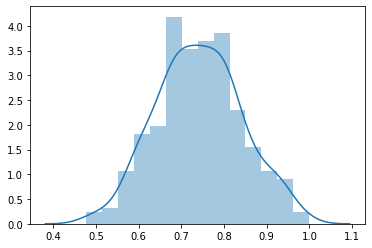

In [15]:
# correctness = np.array(correctness) 
over_080 = len([c for c in correctness if c > 0.8])
print('Over 0.80: {:.1f}%({}/{})'.format(over_080/len(correctness)*100, over_080, len(correctness)))
sns.distplot(correctness)

# スキルごとの正解率を出す

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, random_split

import os
import sys
import time
import datetime
import logging
import random
import pickle
from pathlib import Path
import math
from math import log, ceil
from typing import List, Tuple, Set, Dict
from collections import defaultdict

import click
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
from src.data import QandAEmbedder, slice_d
from src.config import Config
from model.basedkt import BaseDKT


print('PyTorch:', torch.__version__)
# dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dev = torch.device('cpu')
print('Using Device:', dev)


def get_config():
    default_dict = {
        'common_name': '',
        'section_name': '',

        'debug': False,
        'model_name': str,
        'load_model': '',
        'plot_heatmap': False,
        'plot_lc': False,
        'source_data': 'original_ASSISTmentsSkillBuilder0910',  # SOURCE_ASSIST0910_ORIG,
        'ks_loss': False,
        'extend_backward': 0,
        'extend_forward': 0,
        'epoch_size': 200,
        'sequence_size': 20,
        'lr': 0.05,
        'n_skills': 124,
        'cuda': True,

        'batch_size': 100,
    }
    config_dict = default_dict
    projectdir = Path(os.path.dirname(os.path.realpath('.')))
    config = Config(config_dict, projectdir=projectdir)
    return config

config = get_config()

model_name = 'baselstm'
# Parameters
n_skills = 326
batch_size, n_hidden, n_skills, n_layers = 100, 200, n_skills, 2
batch_size = 1
n_output = n_skills
PRESERVED_TOKENS = 2  # PAD, SOS
onehot_size = 2 * n_skills + PRESERVED_TOKENS
n_input = ceil(log(2 * n_skills))

INPUT_DIM, ENC_EMB_DIM, ENC_DROPOUT = onehot_size, n_input, 0.6
OUTPUT_DIM, DEC_EMB_DIM, DEC_DROPOUT = onehot_size, n_input, 0.6
HID_DIM, N_LAYERS = n_hidden, n_layers
N_SKILLS = n_skills
# OUTPUT_DIM = n_output = 124  # TODO: ほんとはこれやりたい


def get_model():
    model = BaseDKT(
        config,
        dev, model_name, n_input, n_hidden, n_output, n_layers, batch_size
    )
    checkpoint_path = '../models/201908010039_baselstm_0.6272209630147144.160'
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'), strict=False)
    model.eval()
    return model

model = get_model()


def predict_ks_from_history(history):
    # Transform to -> [(q1,a1),..]
    input = list()
    with open('../data/Asteria_Eng_ver5.1_dic.pickle', 'rb') as f:
        problems_dic = pickle.load(f)
    for h in history:
        ans = h['answer_result']
        sid = h['lo_id']
        sid_i = problems_dic[sid]
        input.append(
            (sid_i, ans)
        )

    #
    M = 326
    sequence_size = 20
    qa_emb = QandAEmbedder(M, sequence_size)

    xy_seq = slice_d(input, x_seq_size=sequence_size, type='base', sliding_window=0, reverse=True)[0] # most recent
    # TODO: inputが短いと、list index out of rangeになる
    sid_oh = qa_emb.sequenceToOnehot(xy_seq[1:])
    x_tensor = torch.Tensor([sid_oh])#.to(dev)
#     print(x_tensor.shape) #=> [21,654]

    # ################
    input = x_tensor
    compressed_sensing = True
    if compressed_sensing and onehot_size != n_input:
        SEED = 0
        torch.manual_seed(SEED)
        cs_basis = torch.randn(onehot_size, n_input).to(dev)
        input = torch.mm(
            input.contiguous().view(-1, onehot_size), cs_basis)
        # https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn
        # inputの説明を見ると、input of shape (seq_len, batch, input_size)　とある
        input = input.view(batch_size, sequence_size, n_input)
    input = input.permute(1, 0, 2)

    out = model(input)
    pred = torch.sigmoid(out[-1])  # [0, 1]区間にする
    predicted_ks = pred
    # predicted_ks.shape => [1,326]
    ks = predicted_ks.detach().numpy()[0]
#     print(ks)
    # RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
    # model.eval()しても上のようなエラーが出た。どうしてだろう。
    # ################

    problems_dic_invert = {v:k for k,v in problems_dic.items()}
    result = []
    for i in range(predicted_ks.shape[1]):
        result.append(
            {
                'lo_id': problems_dic_invert[i],
                'skill_pred': float(ks[i])
            }
        )
    return result



PyTorch: 1.3.0
Using Device: cpu


In [21]:
res = predict_ks_from_history([{"lo_id": "NEL01L06", "answer_result": 1} for _ in range(21)])
for r in res:
    if r['lo_id'] == "NEL01L06":
        print(r)

{'lo_id': 'NEL01L06', 'skill_pred': 0.8667373061180115}


In [22]:
simu = \
[[1 if j > i else 0 for j in range(21)] for i in range(21)] + \
[[0 if j > i else 1 for j in range(21)] for i in range(21)]
simu

[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 [0, 0, 0,

In [25]:
with open('../data/Asteria_Eng_ver5.1_dic.pickle', 'rb') as f:
    problems_dic = pickle.load(f)
problems_dic

{'NEL01L02': 0,
 'NEL09L01': 1,
 'NEL09L02': 2,
 'NEL09L03': 3,
 'NEL09L04': 4,
 'NEL01L01': 5,
 'NEL01L03': 6,
 'NEL01L05': 7,
 'NEL01L06': 8,
 'NEL01L07': 9,
 'NEL02L01': 10,
 'NEL02L02': 11,
 'NEL02L04': 12,
 'NEL03L01': 13,
 'NEL03L02': 14,
 'NEL03L03': 15,
 'NEL03L04': 16,
 'NEL04L01': 17,
 'NEL04L02': 18,
 'NEL04L03': 19,
 'NEL04L04': 20,
 'NEL04L05': 21,
 'NEL05L01': 22,
 'NEL05L02': 23,
 'NEL05L03': 24,
 'NEL05L05': 25,
 'NEL06L01': 26,
 'NEL06L02': 27,
 'NEL06L05': 28,
 'NEL07L01': 29,
 'NEL07L02': 30,
 'NEL07L03': 31,
 'NEL07L04': 32,
 'NEL07L05': 33,
 'NEL08L01': 34,
 'NEL08L02': 35,
 'NEL08L03': 36,
 'NEL08L04': 37,
 'NEL08L05': 38,
 'NEL08L06': 39,
 'NEL09L05': 40,
 'NER01L01': 41,
 'NER01L02': 42,
 'NER01L03': 43,
 'NER01L04': 44,
 'NER02L01': 45,
 'NER02L02': 46,
 'NER02L03': 47,
 'NER02L04': 48,
 'NER03L01': 49,
 'NER03L02': 50,
 'NER04L01': 51,
 'NER04L02': 52,
 'NER04L03': 53,
 'NER04L04': 54,
 'NER04L05': 55,
 'NER04L06': 56,
 'NER05L01': 57,
 'NER05L02': 58,
 'NER05

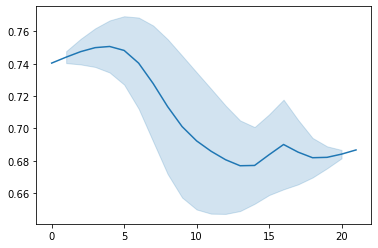

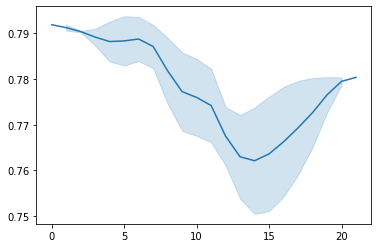

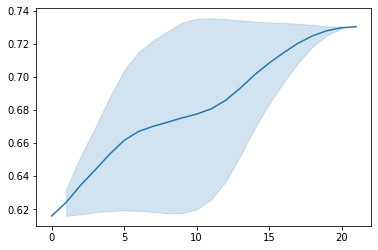

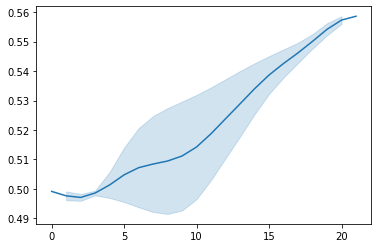

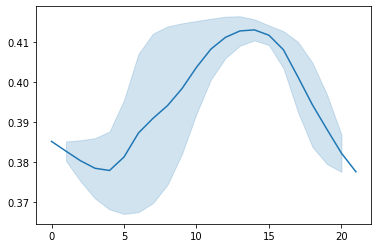

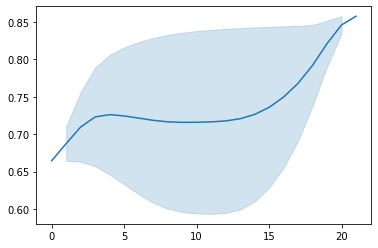

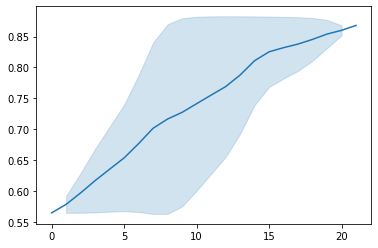

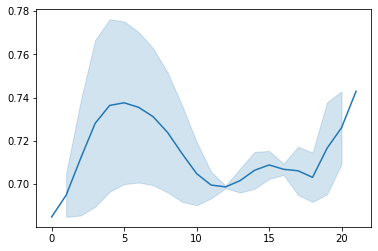

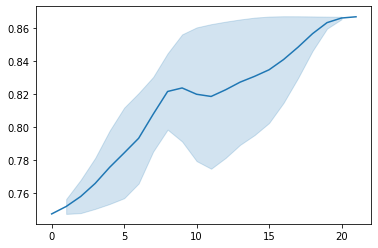

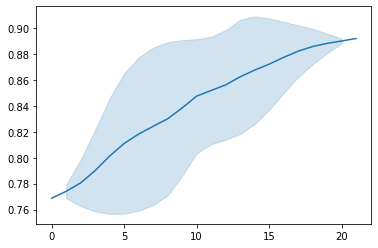

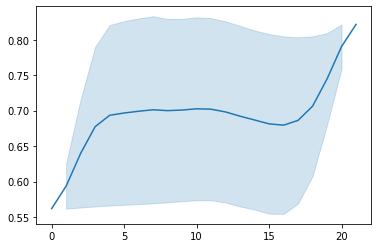

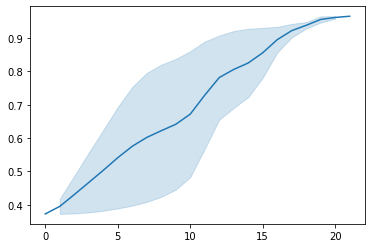

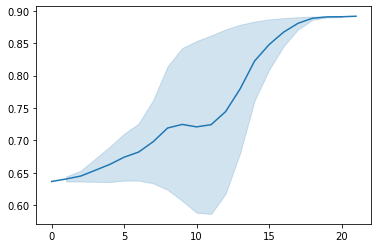

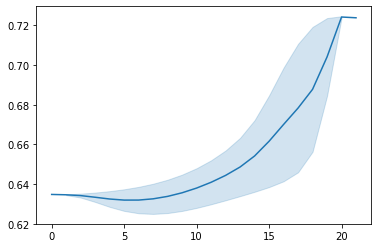

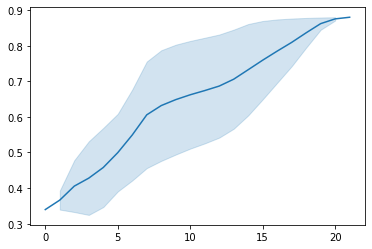

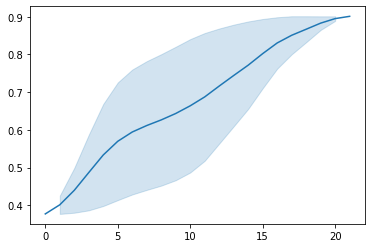

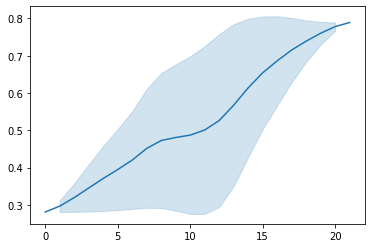

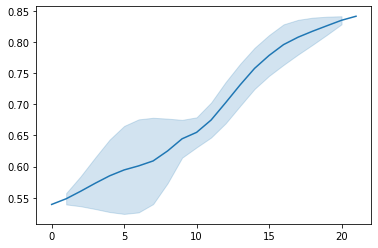

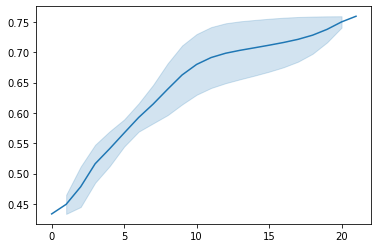

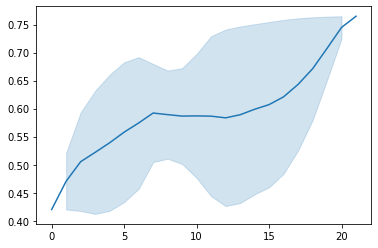

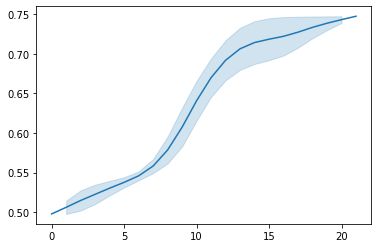

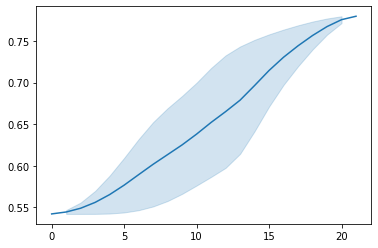

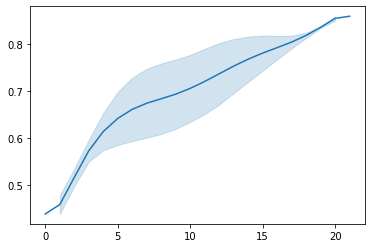

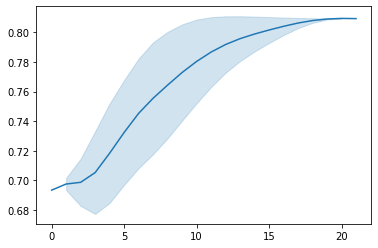

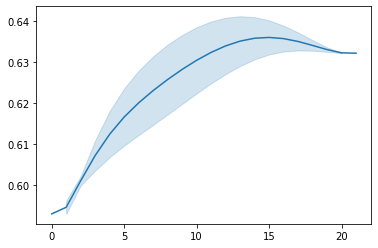

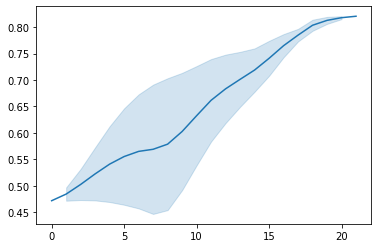

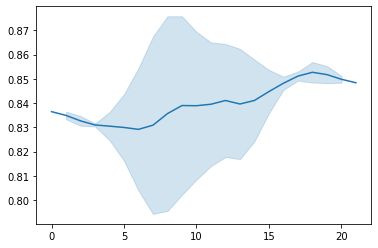

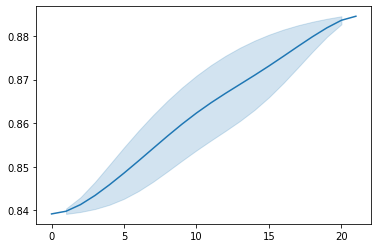

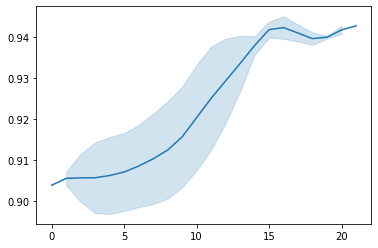

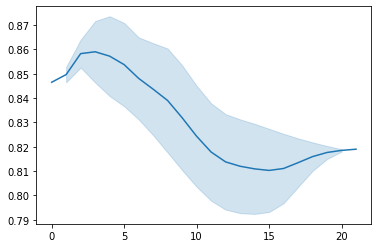

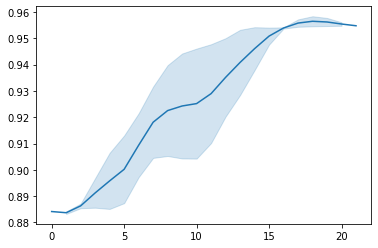

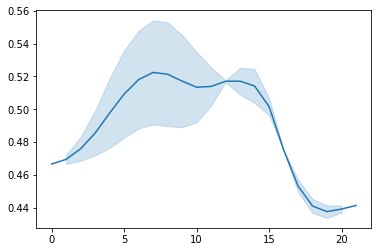

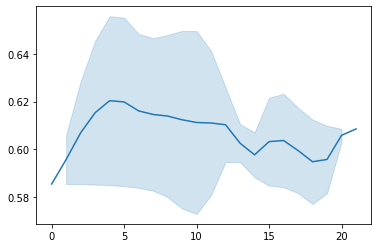

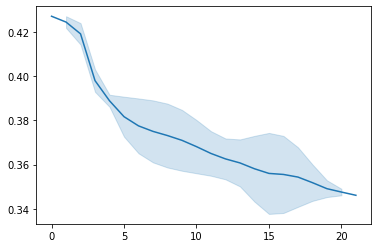

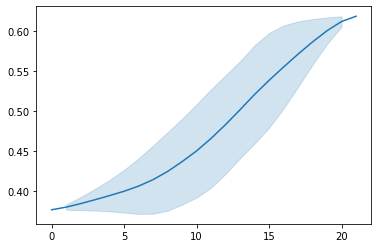

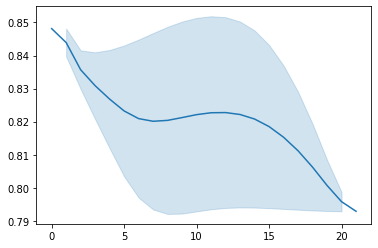

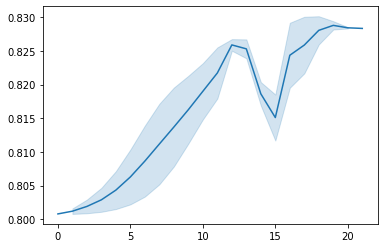

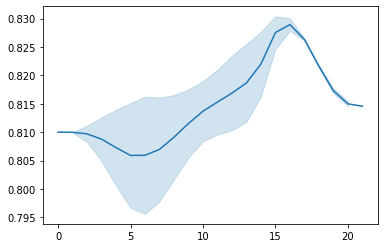

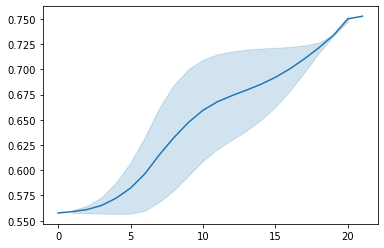

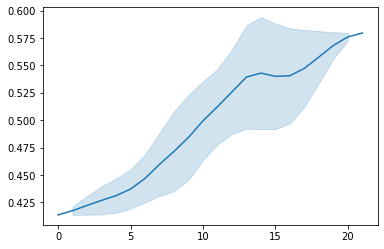

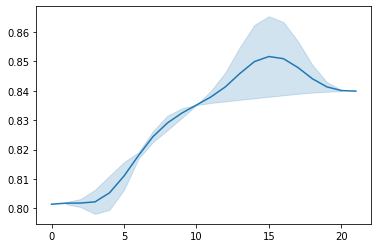

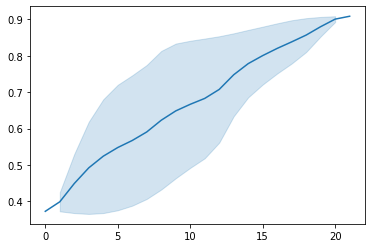

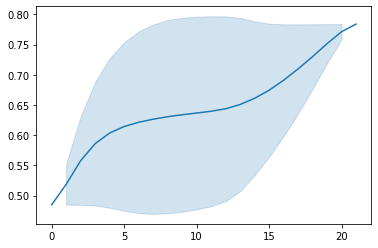

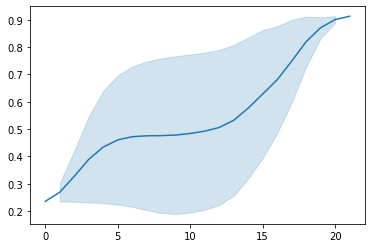

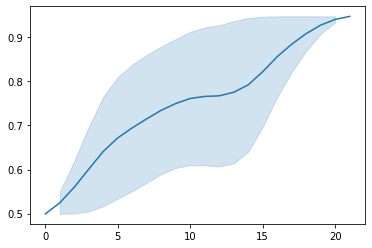

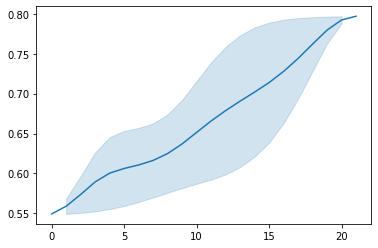

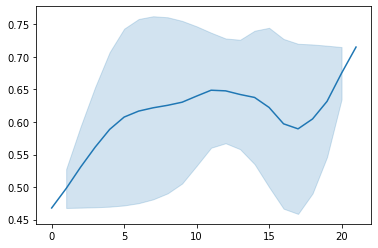

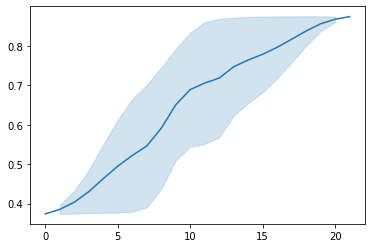

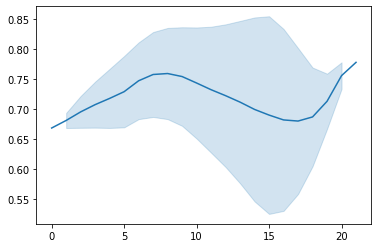

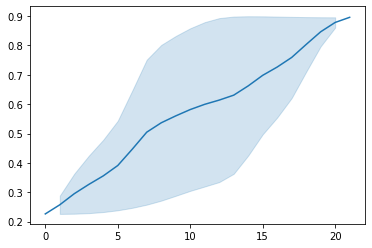

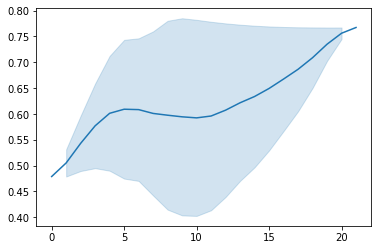

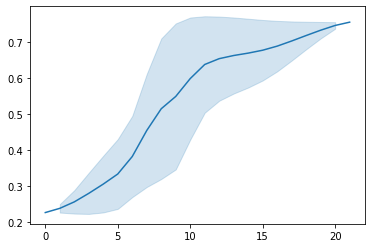

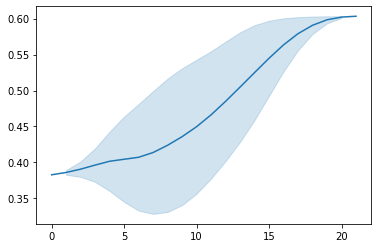

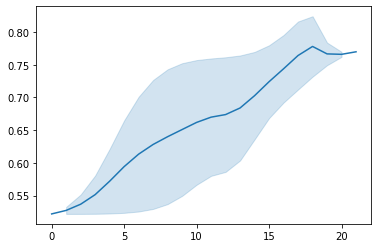

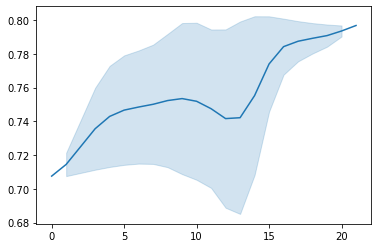

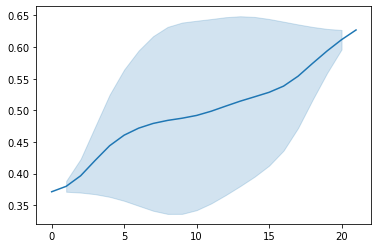

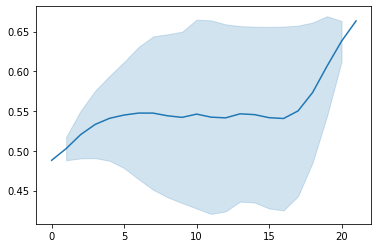

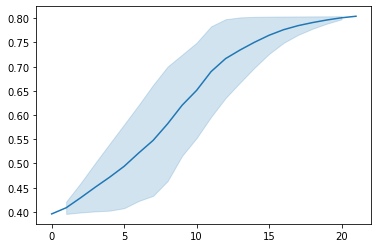

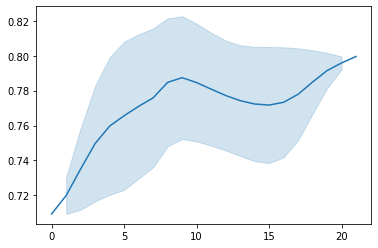

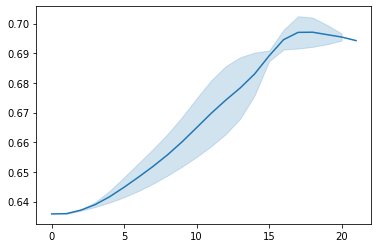

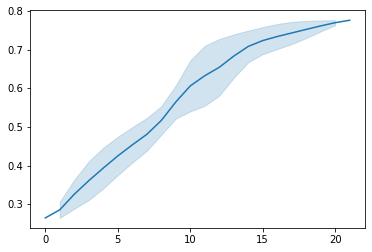

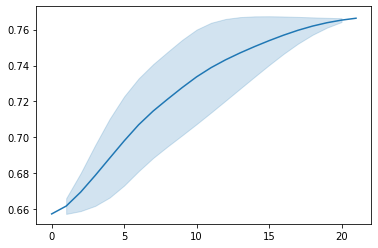

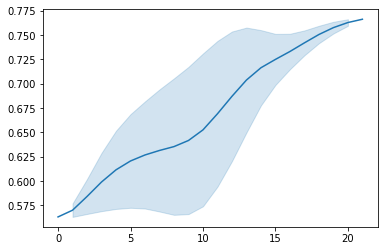

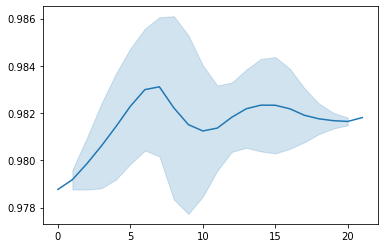

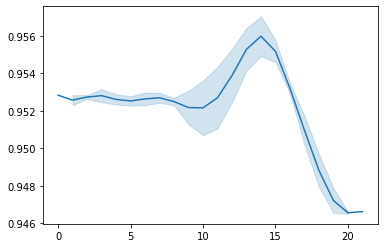

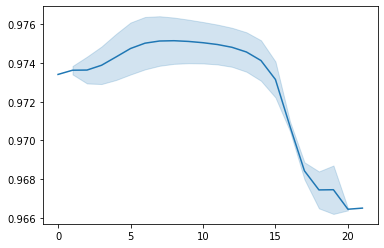

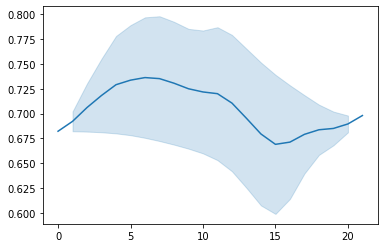

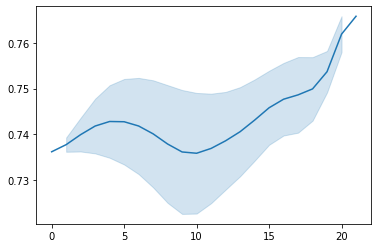

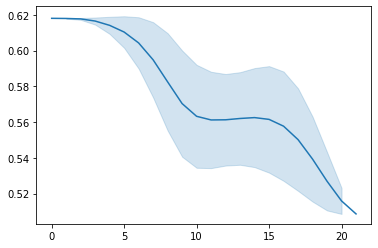

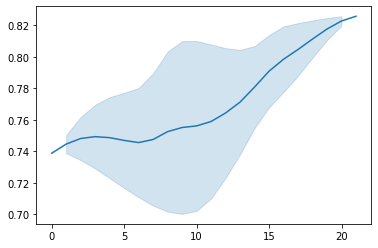

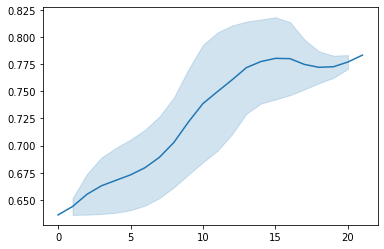

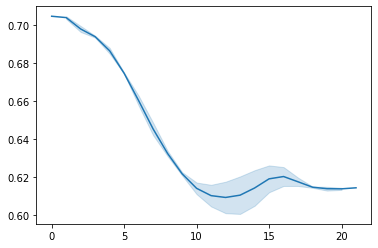

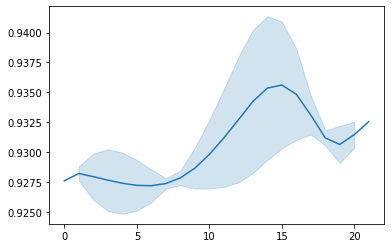

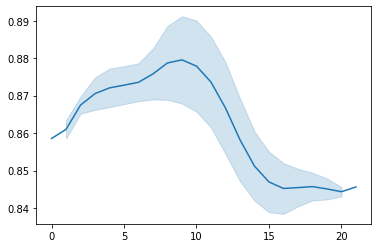

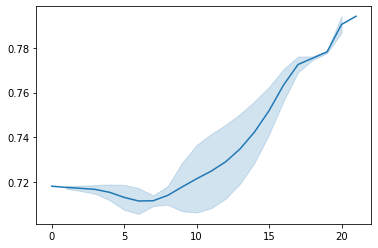

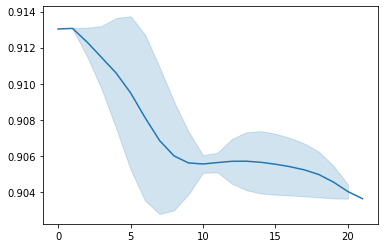

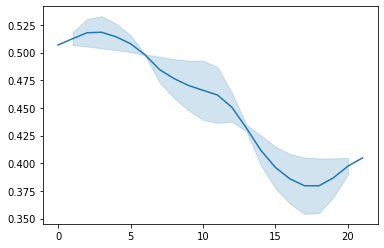

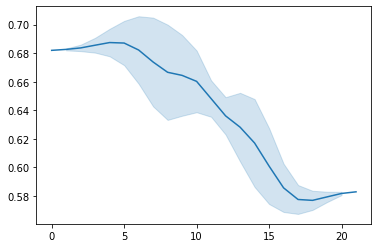

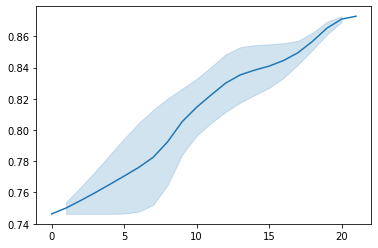

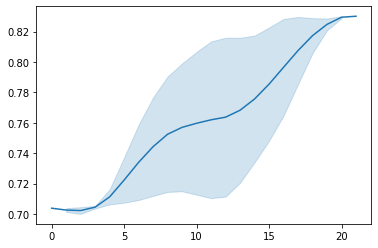

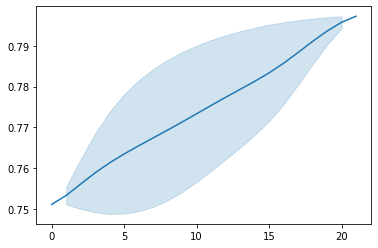

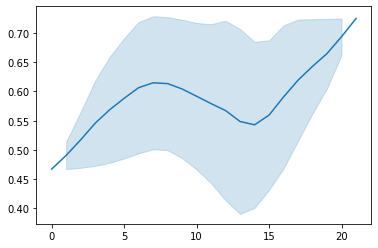

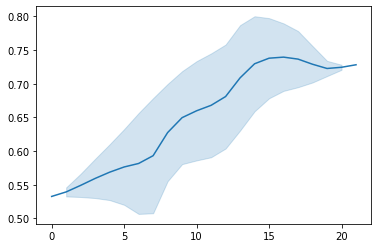

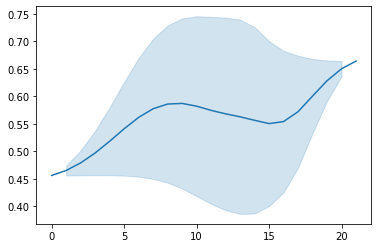

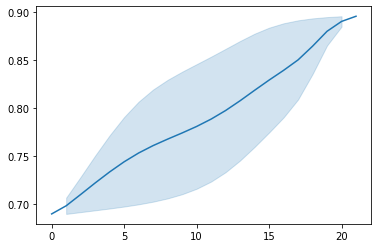

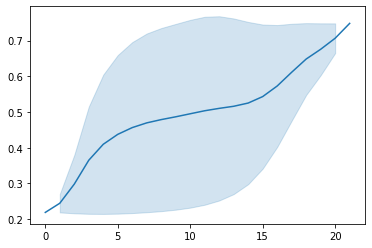

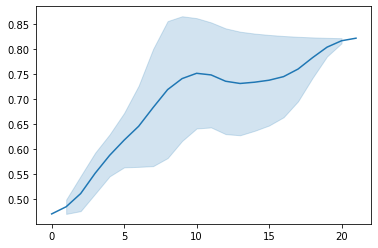

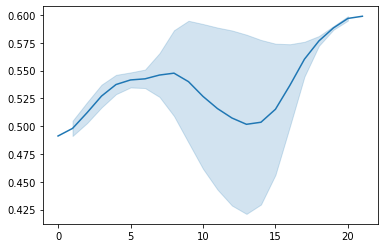

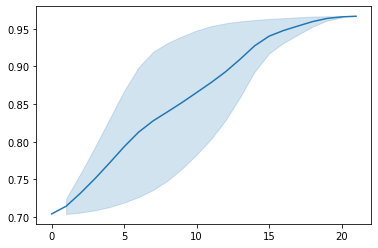

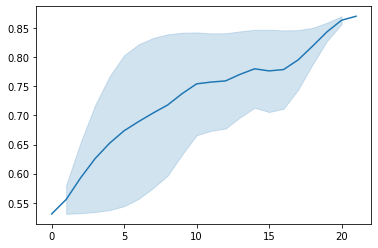

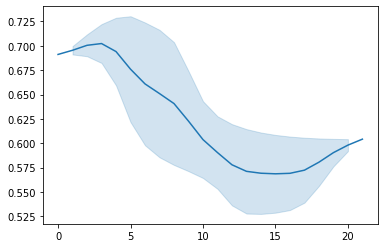

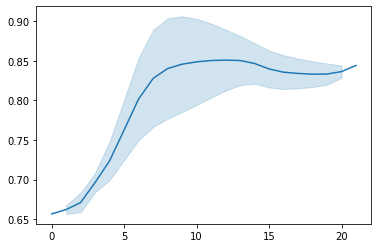

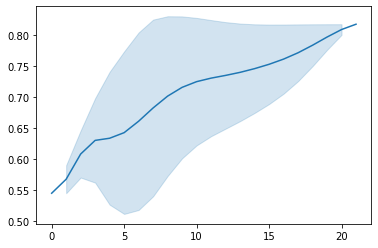

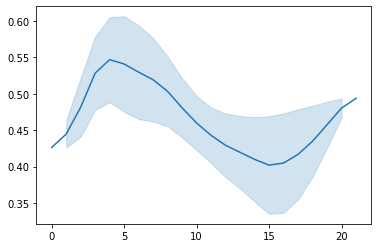

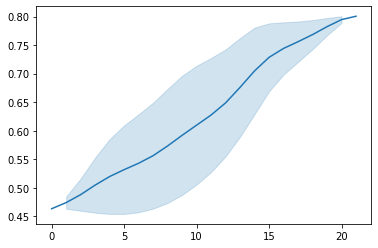

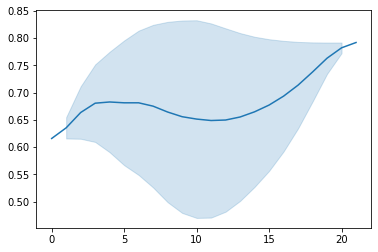

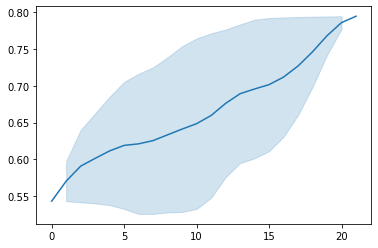

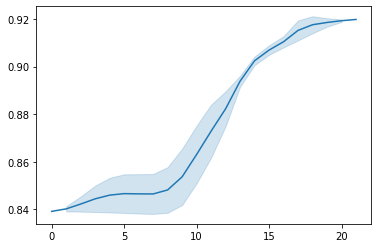

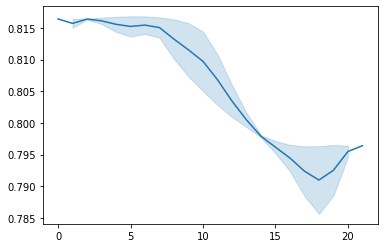

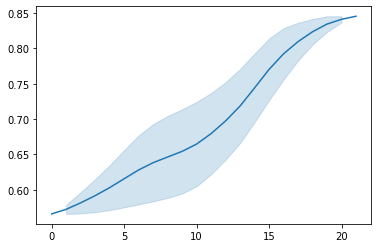

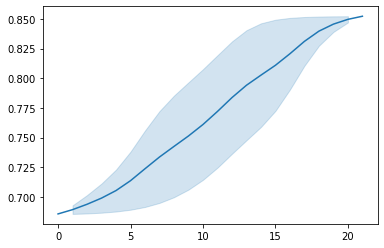

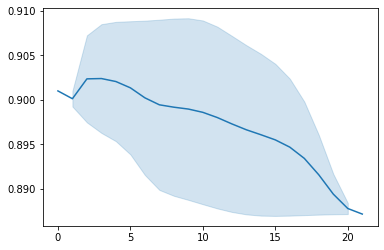

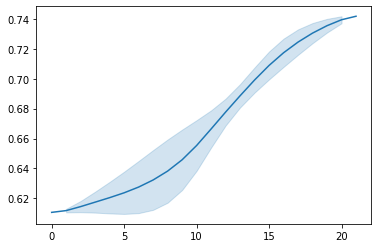

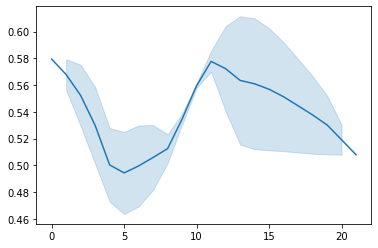

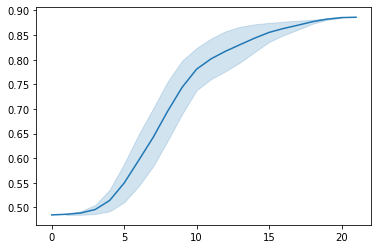

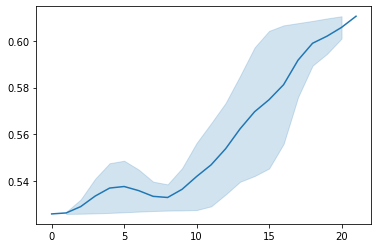

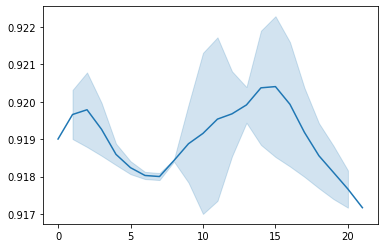

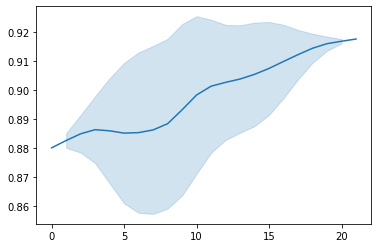

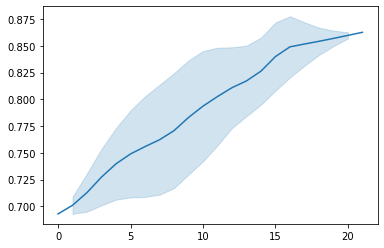

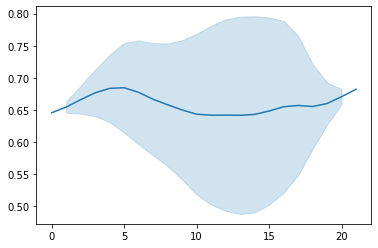

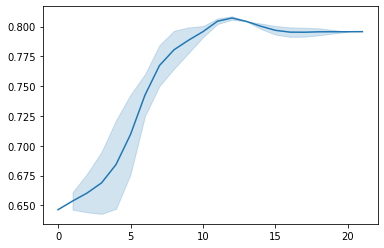

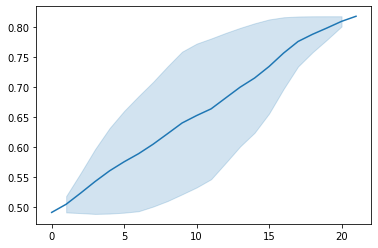

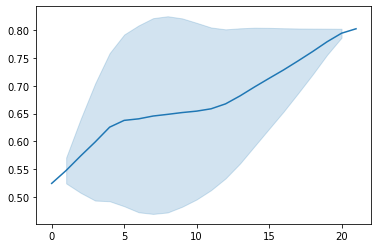

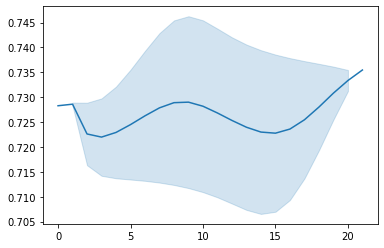

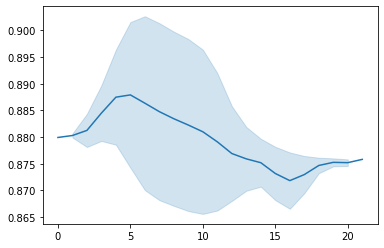

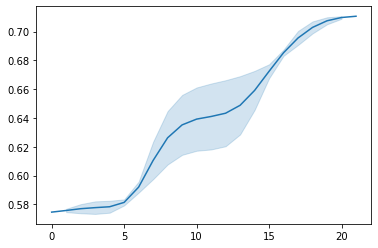

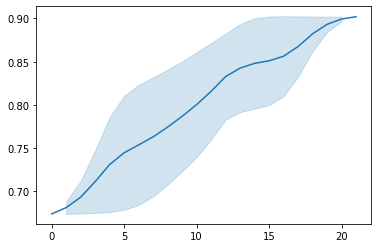

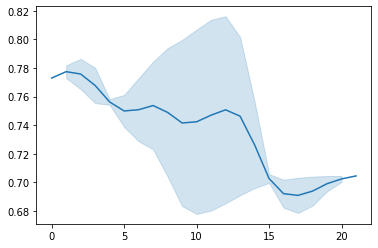

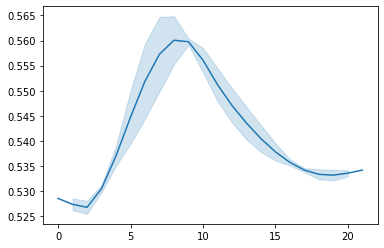

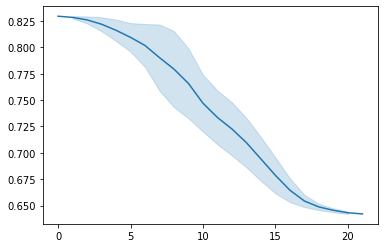

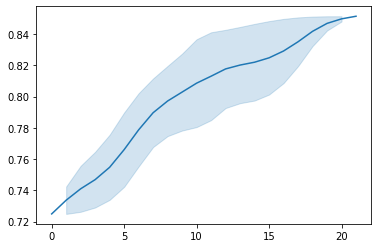

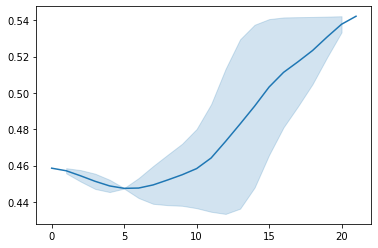

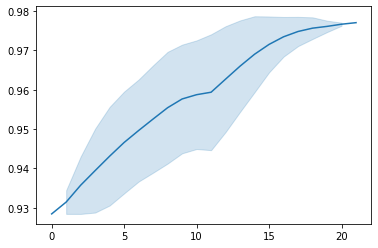

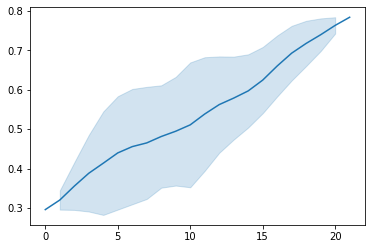

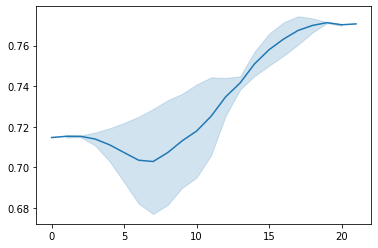

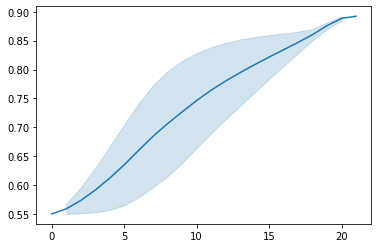

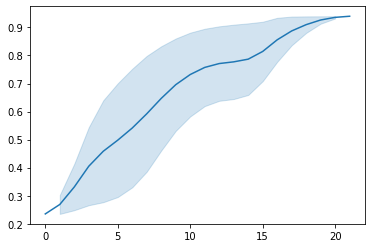

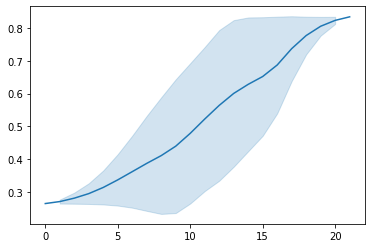

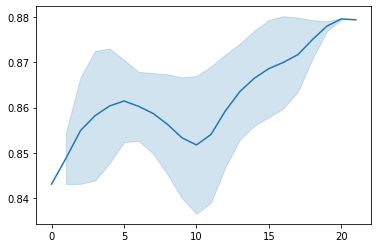

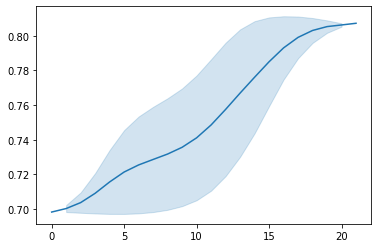

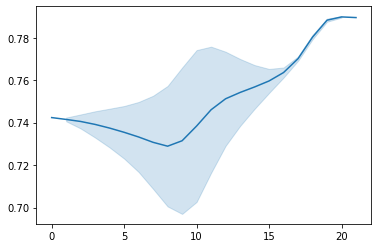

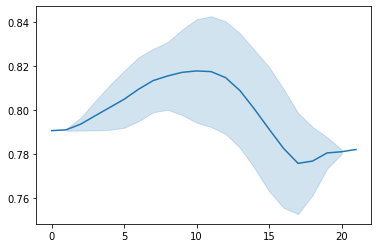

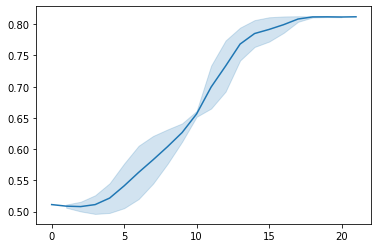

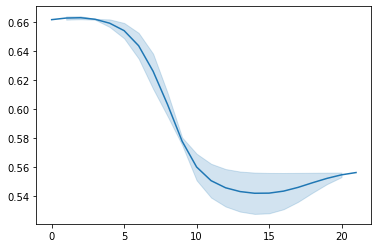

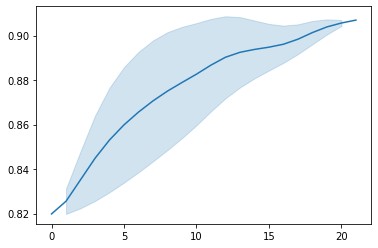

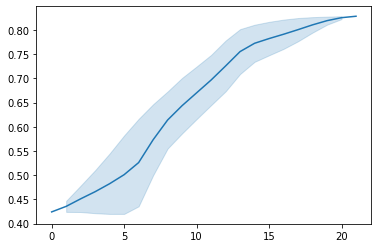

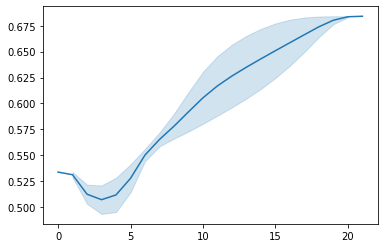

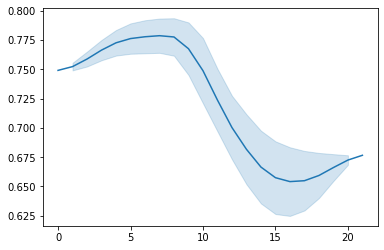

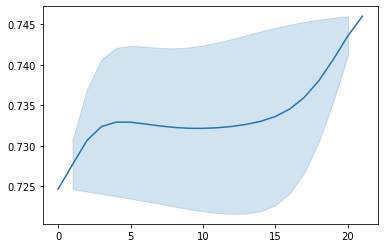

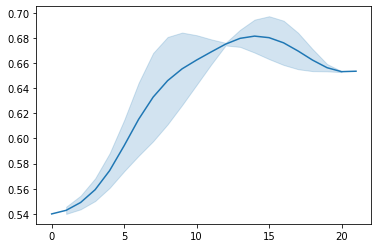

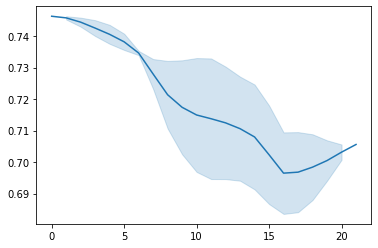

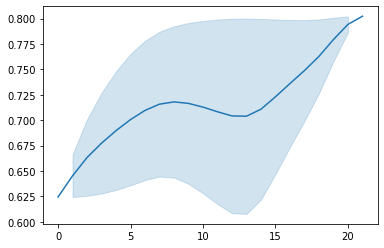

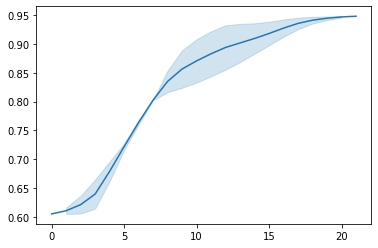

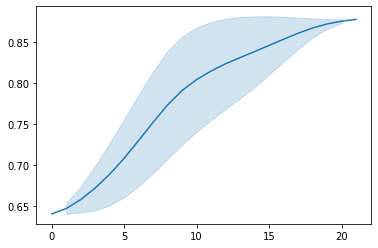

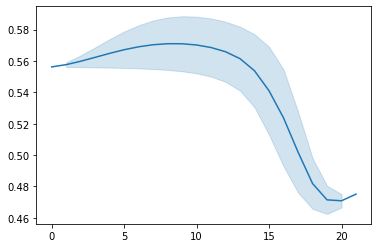

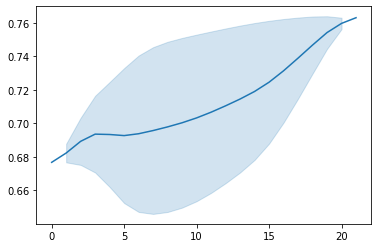

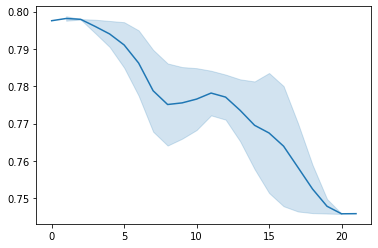

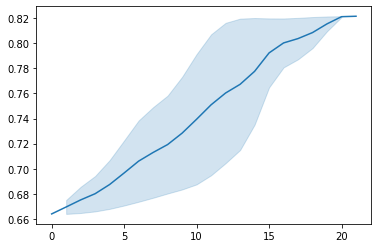

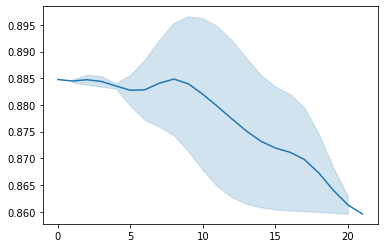

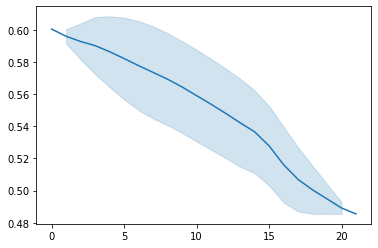

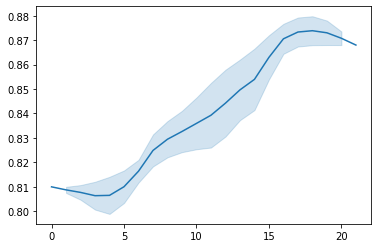

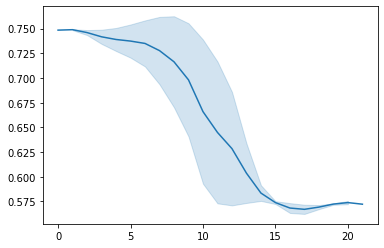

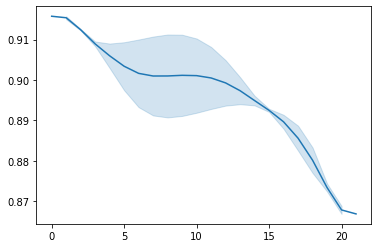

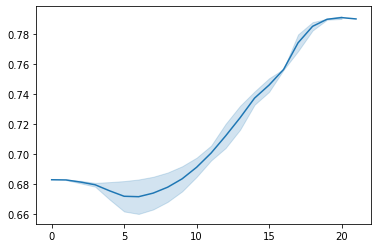

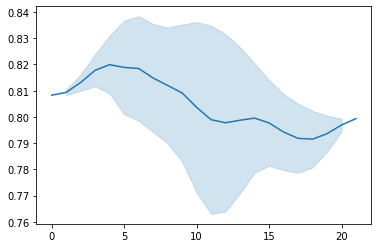

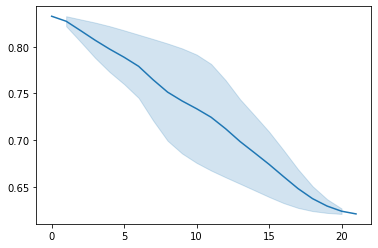

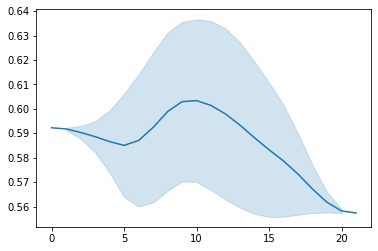

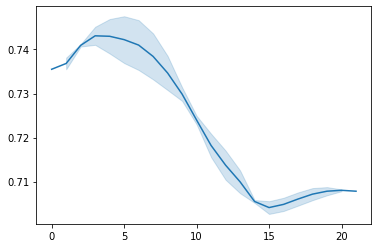

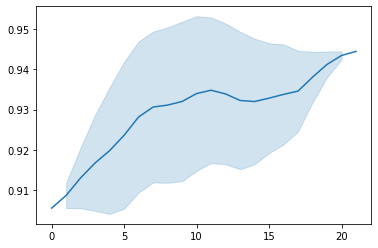

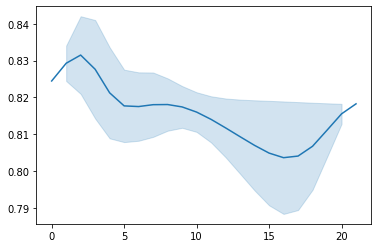

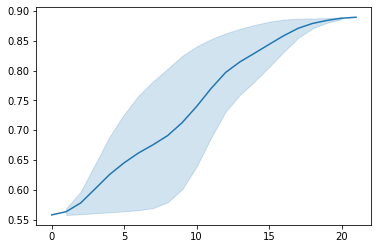

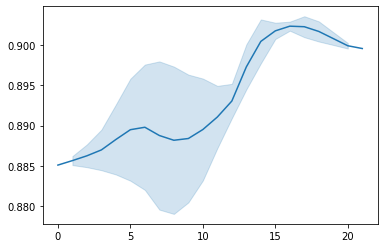

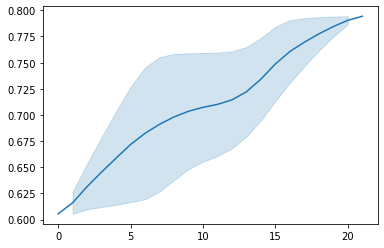

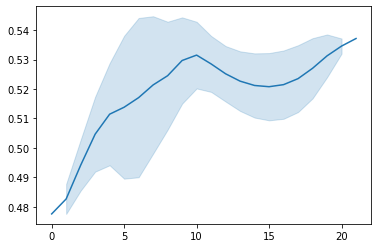

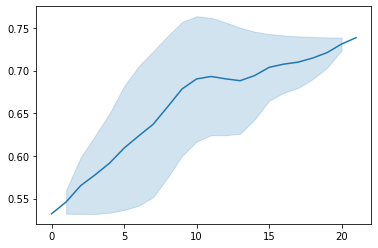

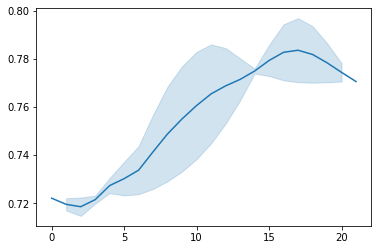

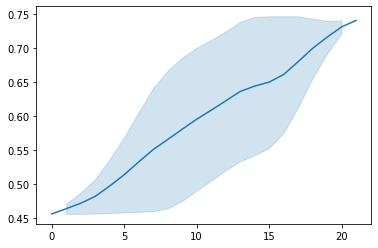

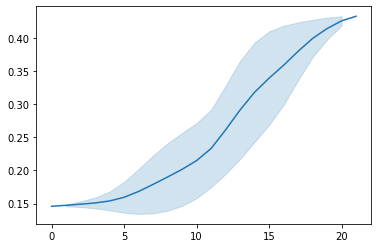

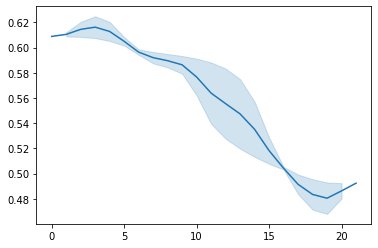

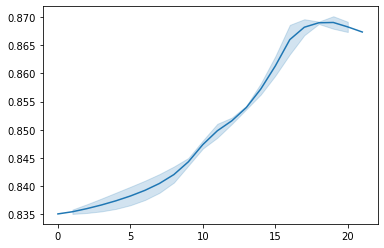

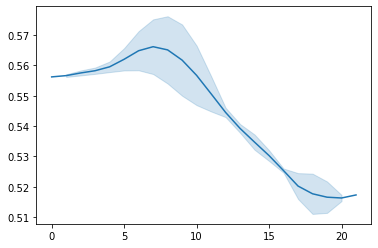

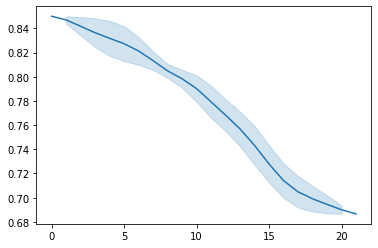

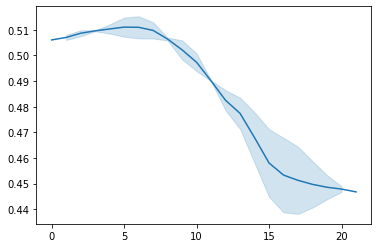

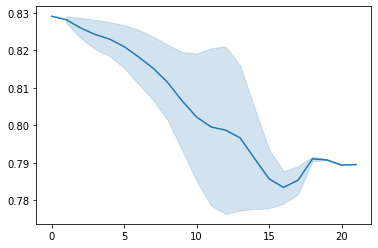

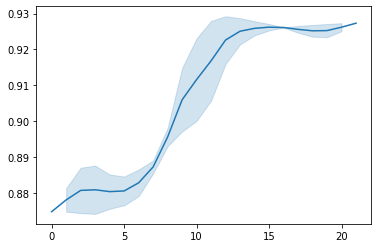

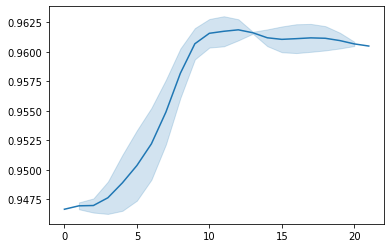

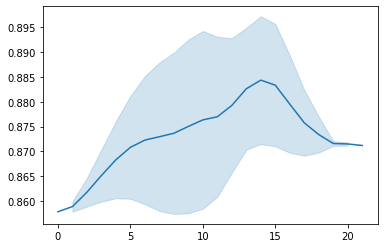

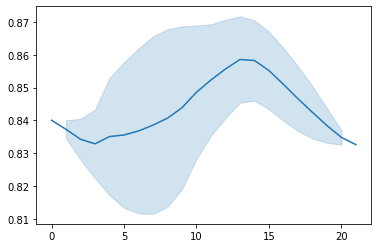

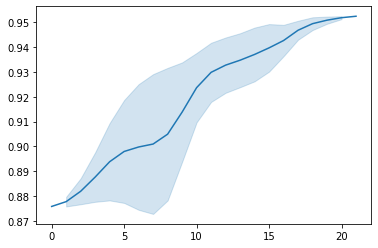

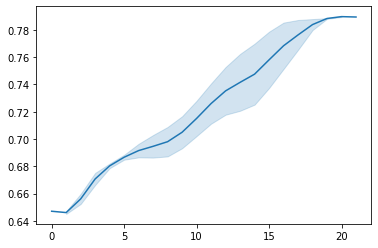

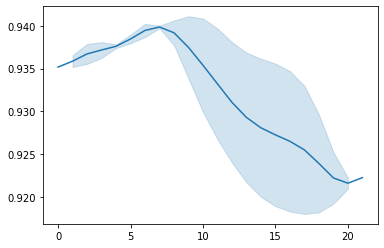

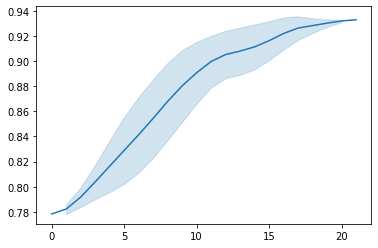

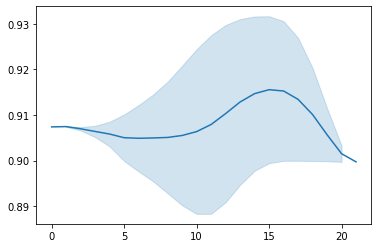

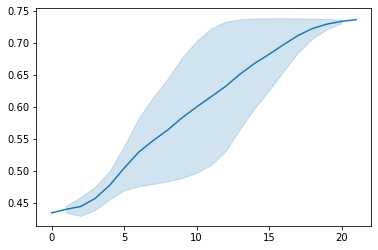

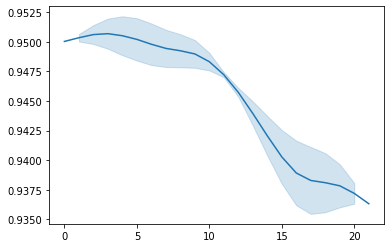

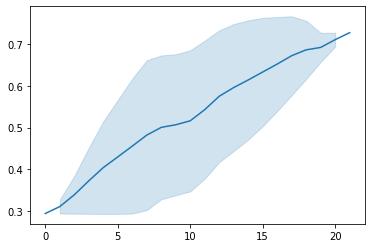

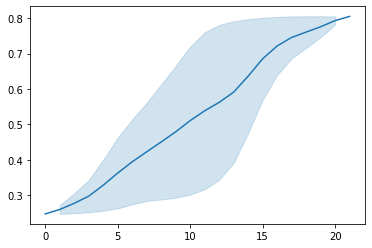

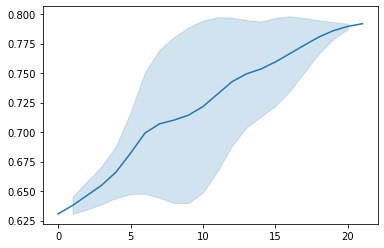

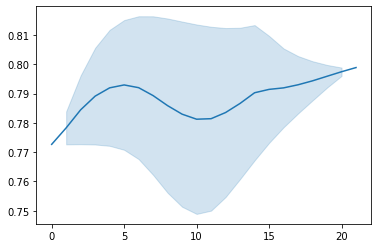

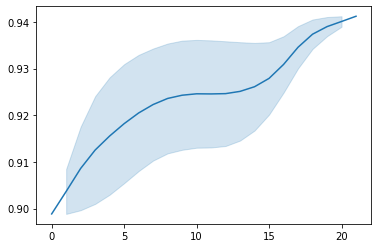

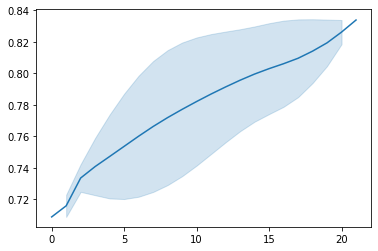

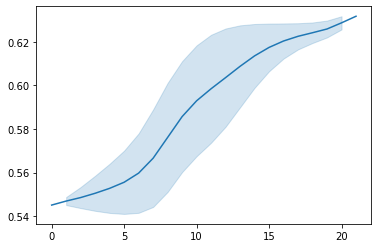

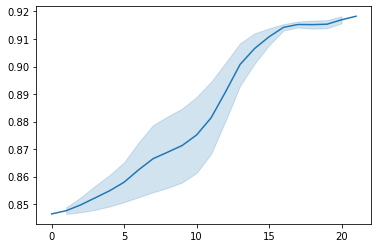

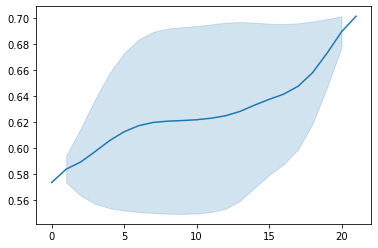

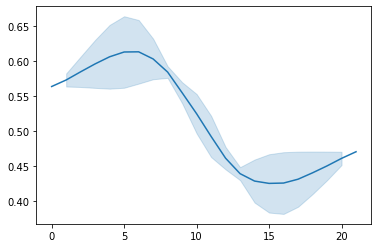

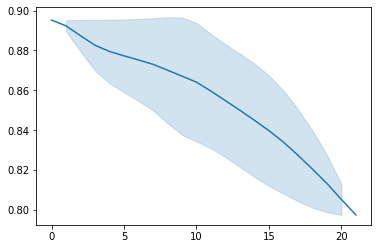

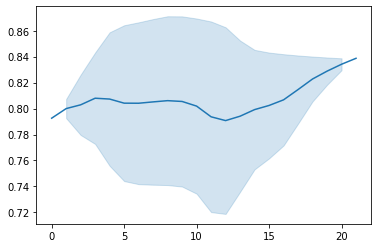

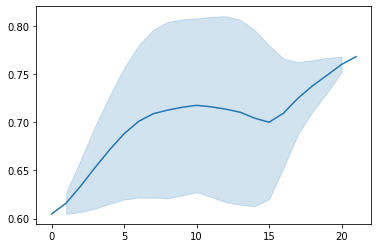

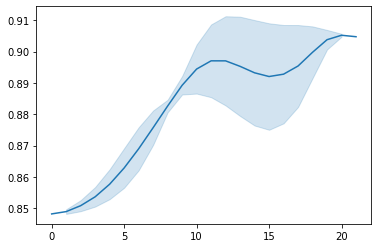

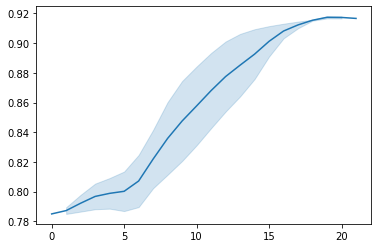

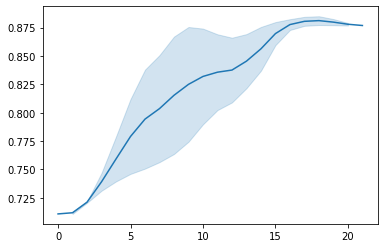

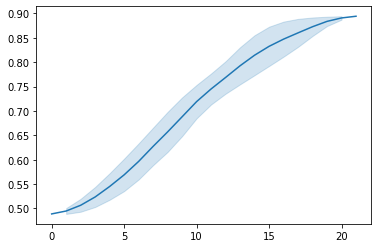

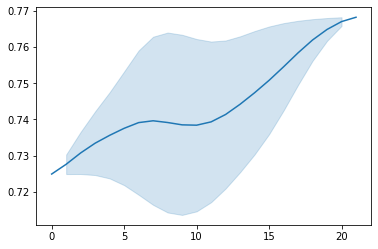

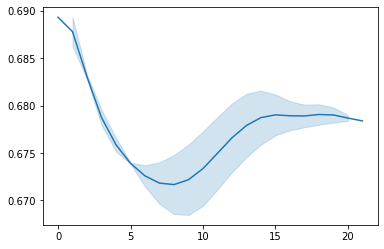

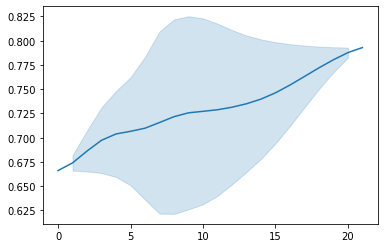

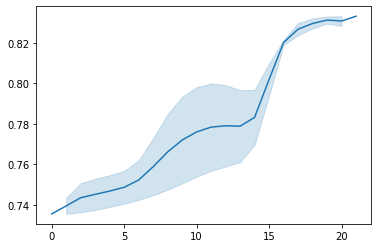

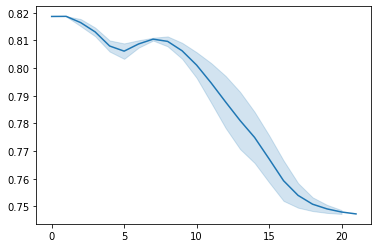

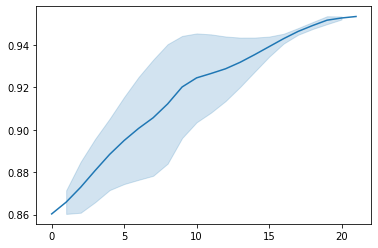

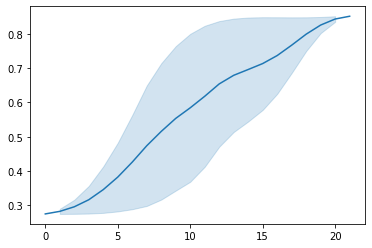

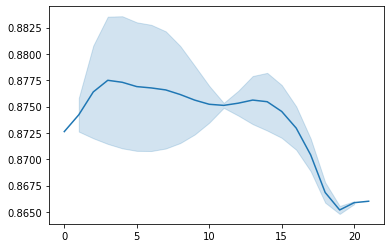

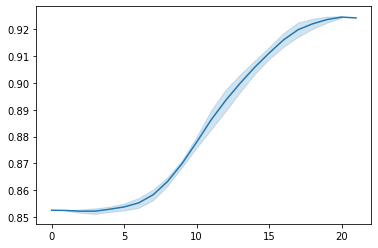

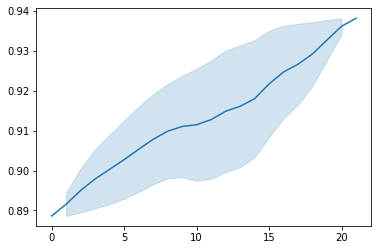

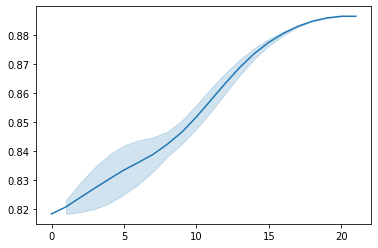

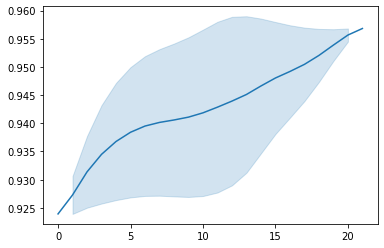

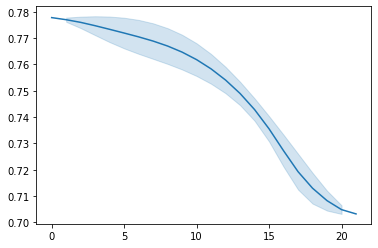

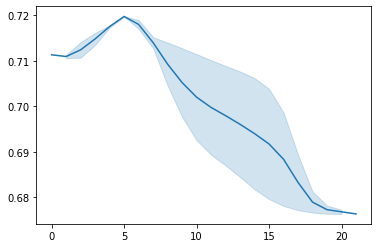

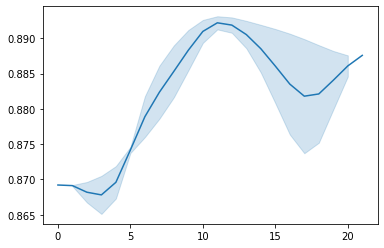

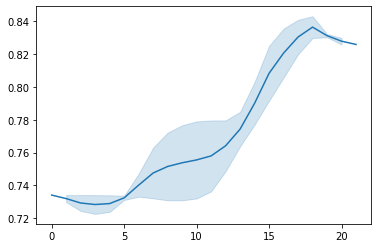

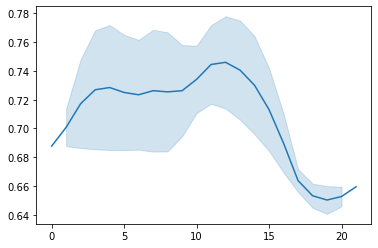

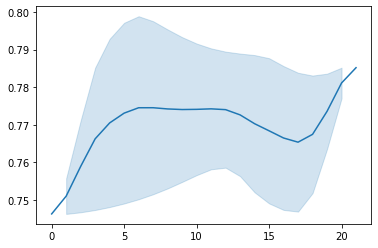

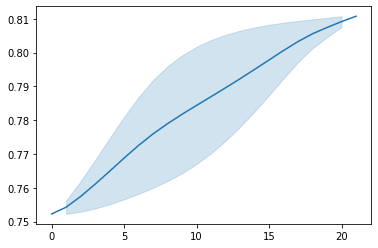

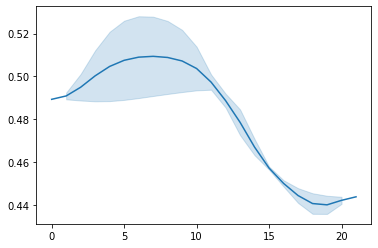

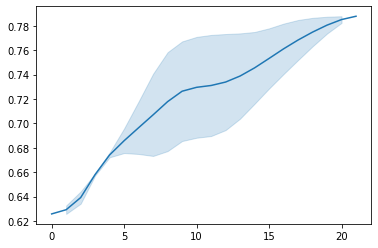

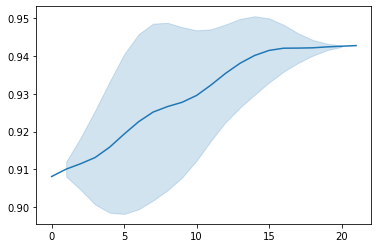

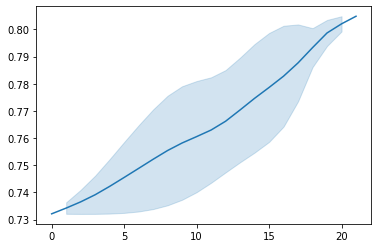

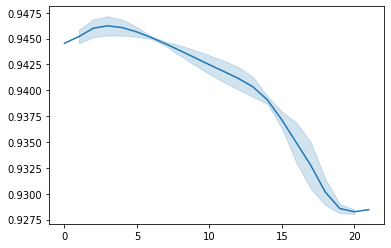

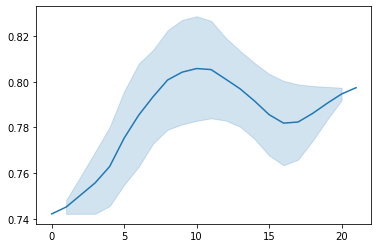

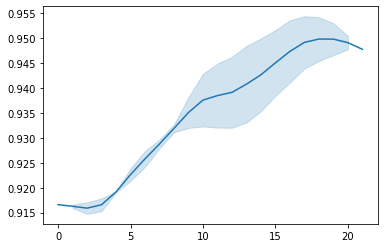

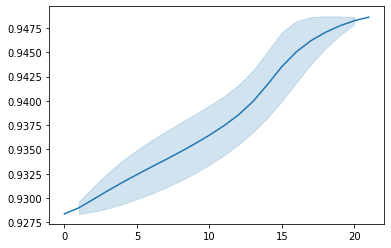

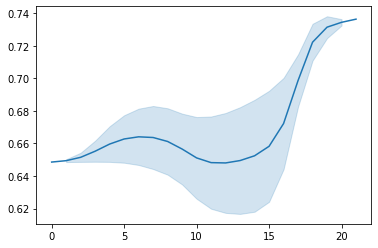

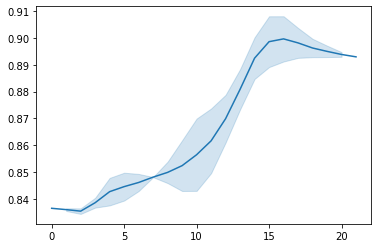

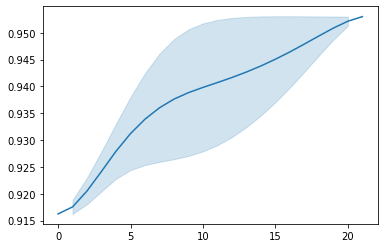

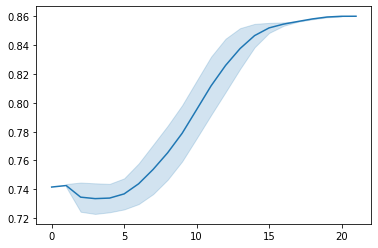

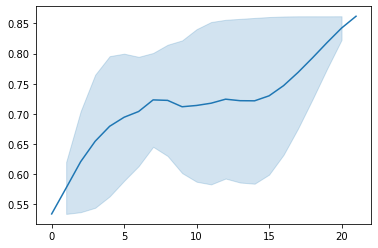

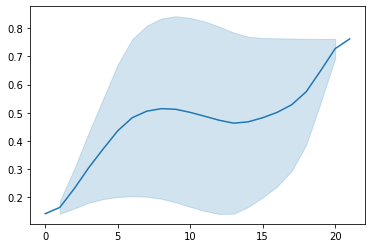

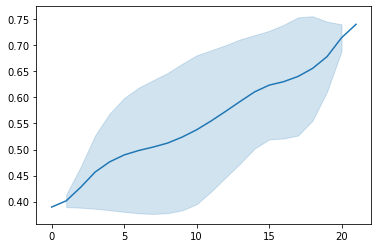

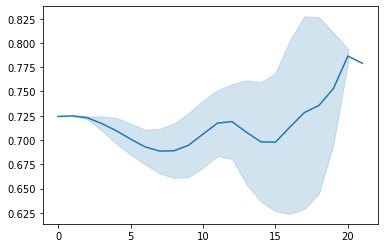

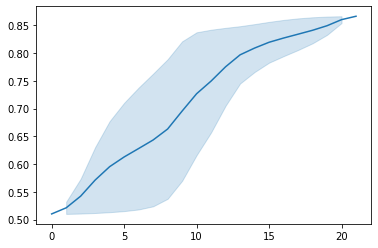

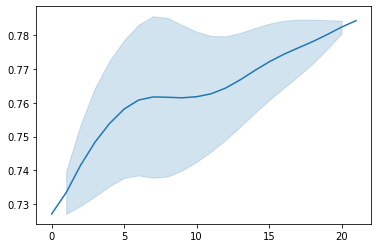

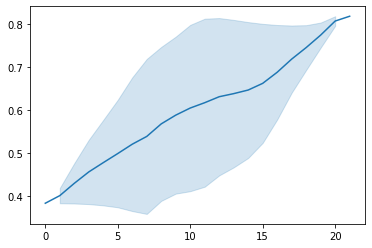

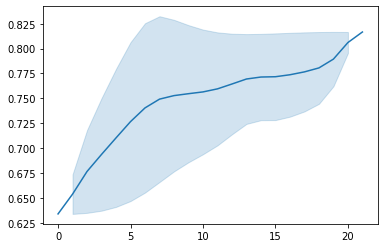

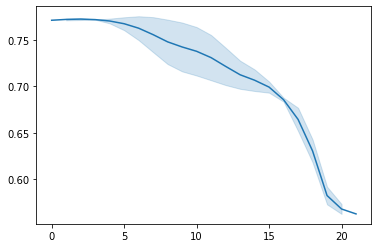

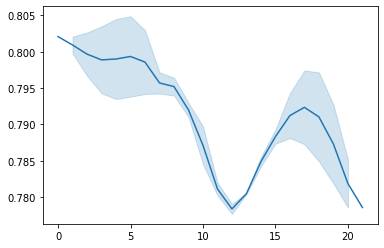

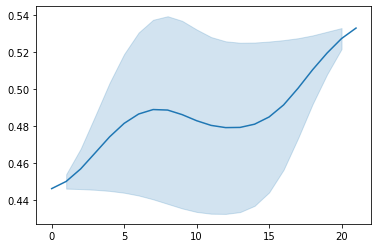

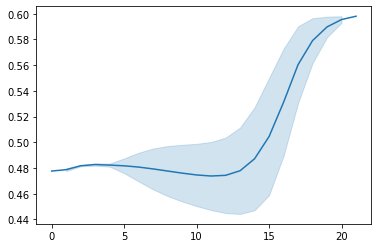

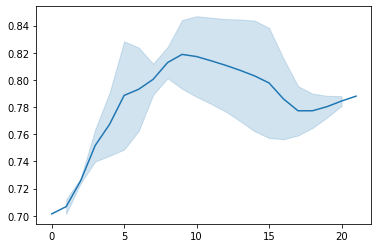

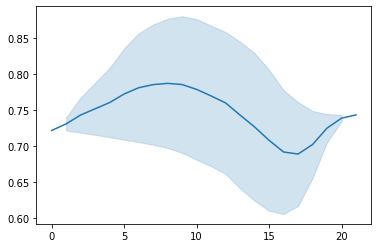

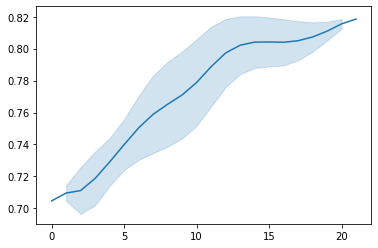

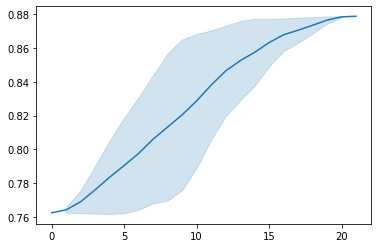

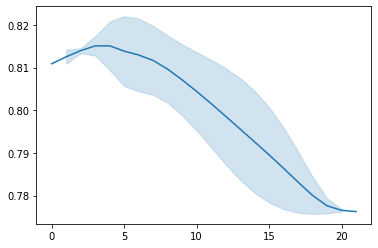

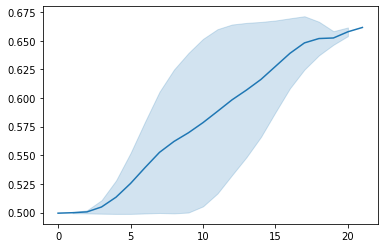

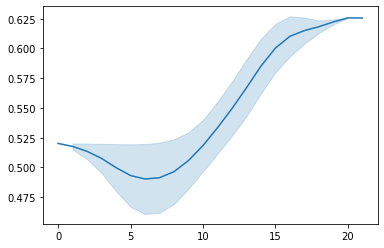

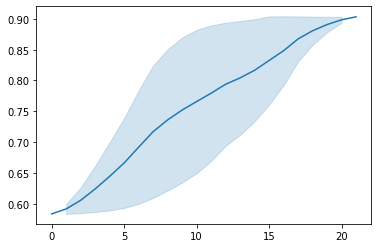

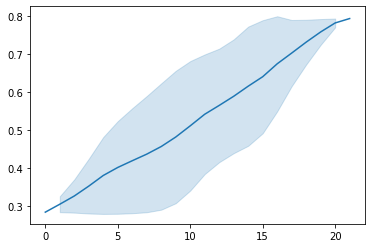

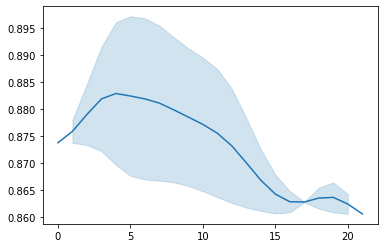

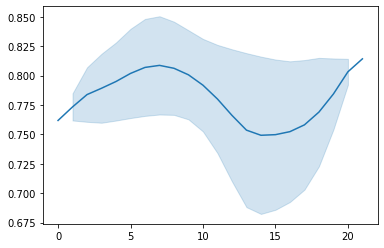

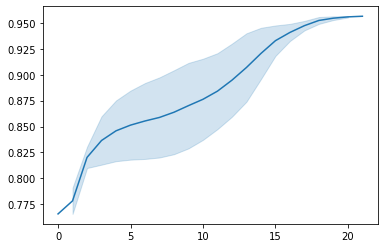

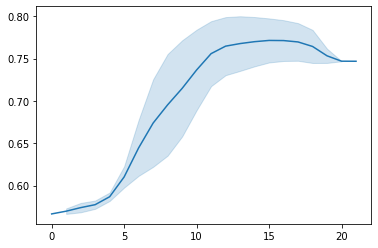

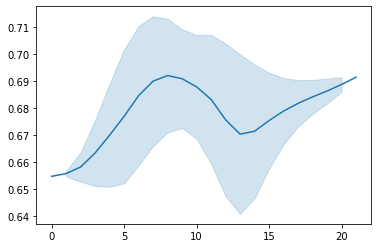

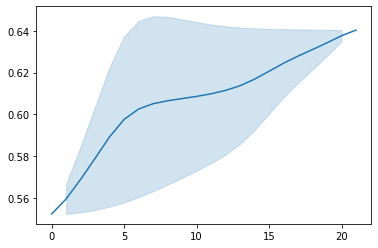

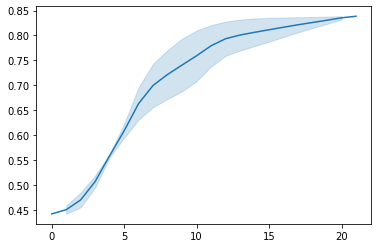

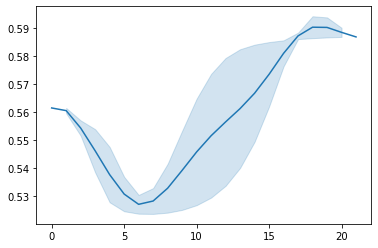

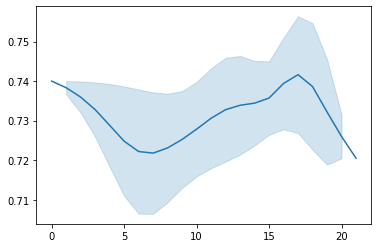

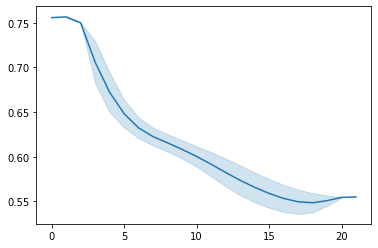

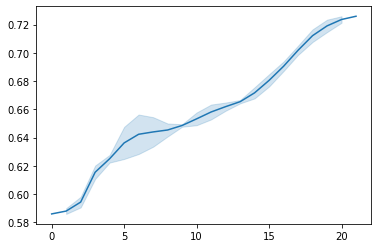

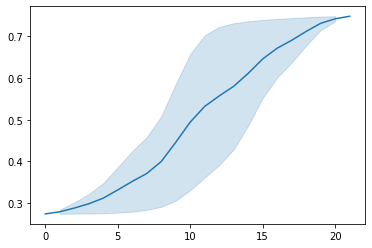

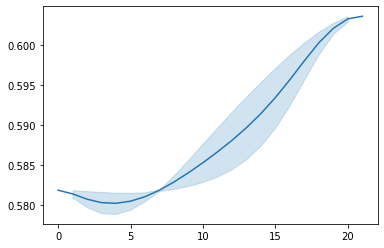

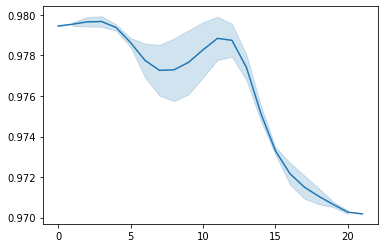

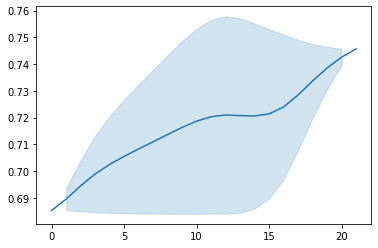

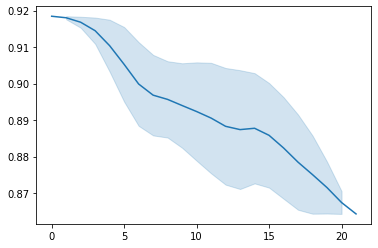

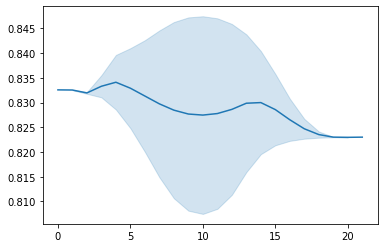

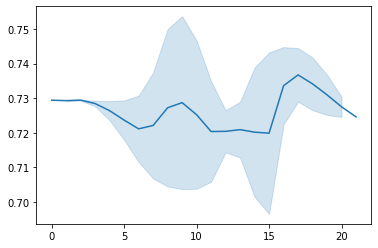

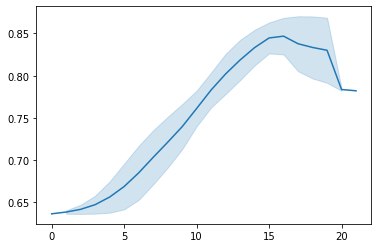

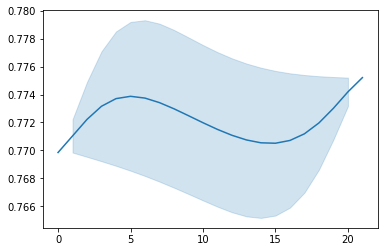

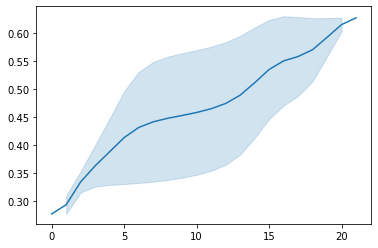

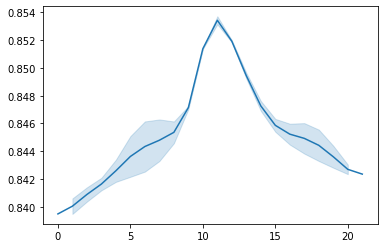

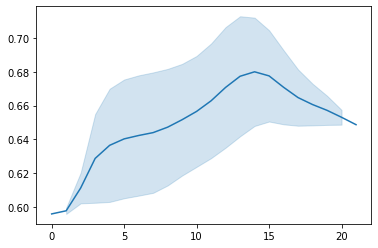

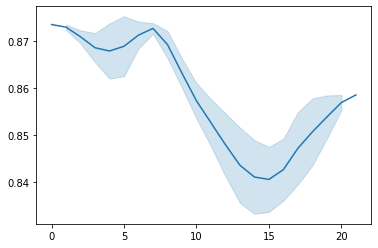

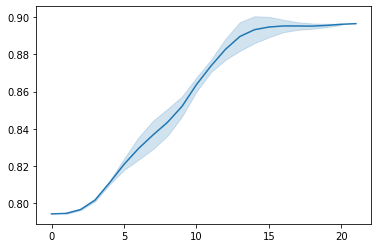

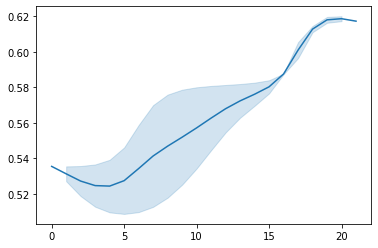

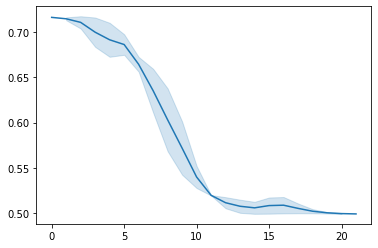

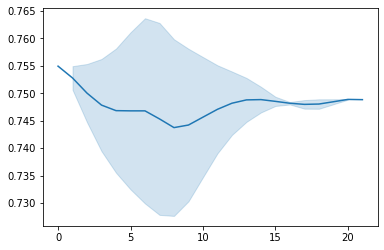

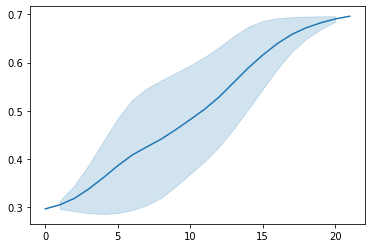

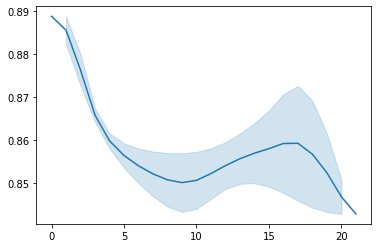

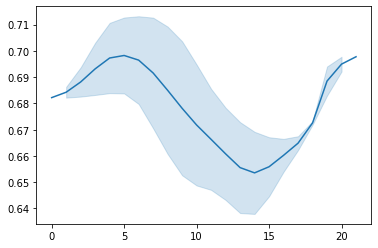

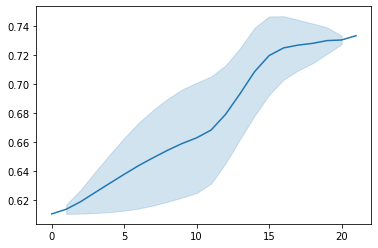

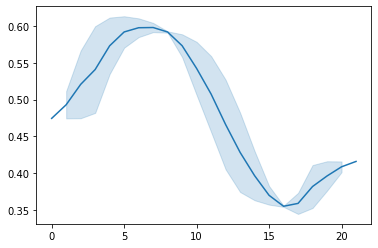

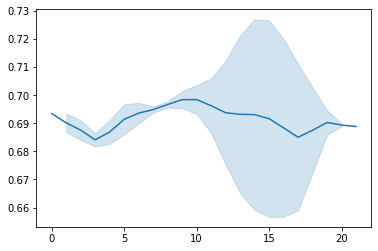

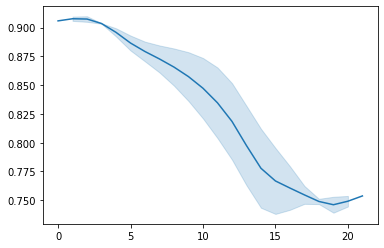

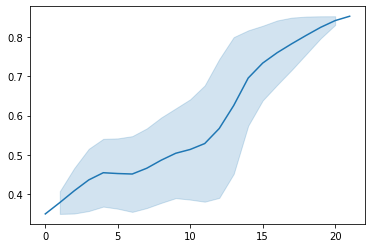

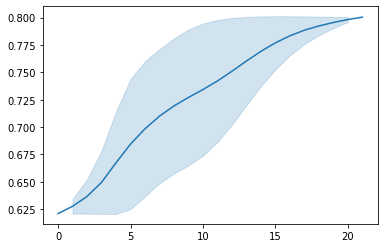

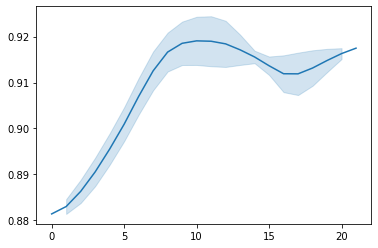

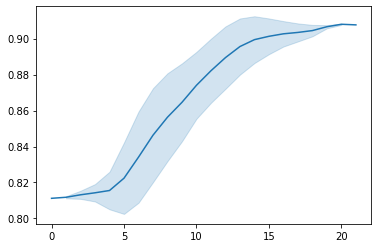

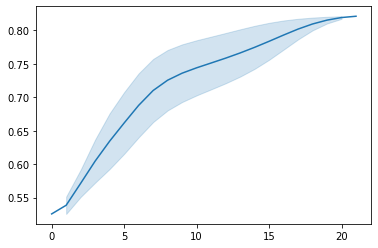

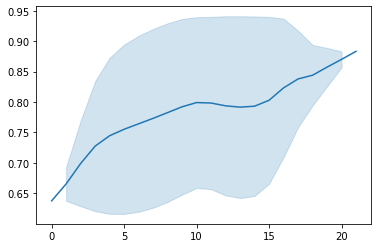

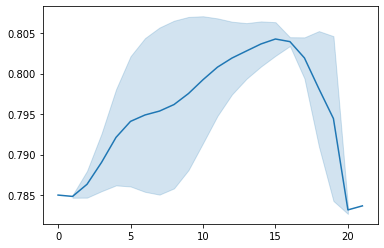

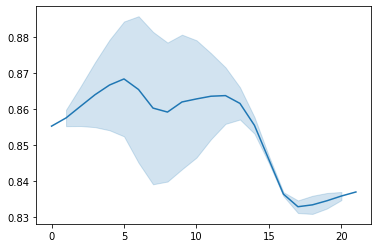

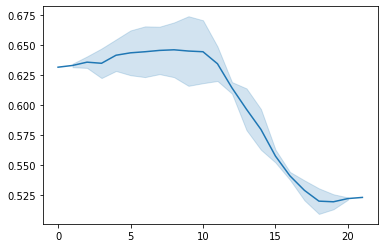

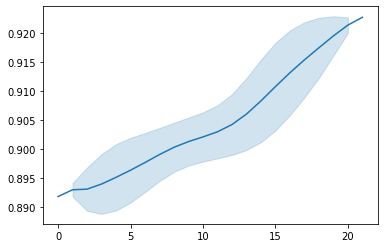

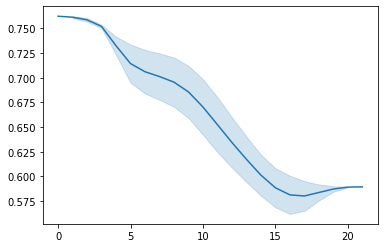

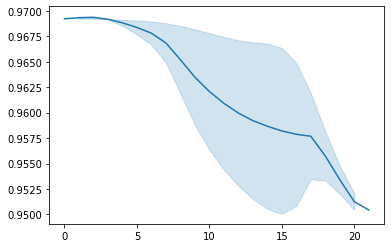

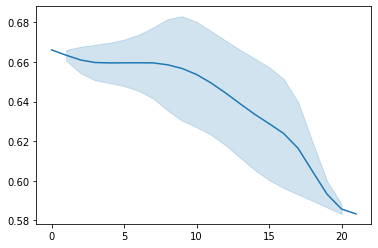

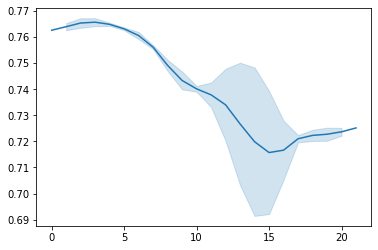

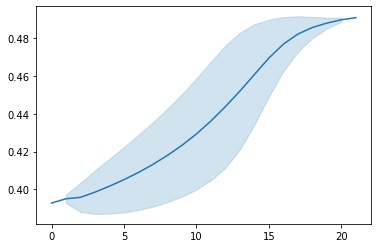

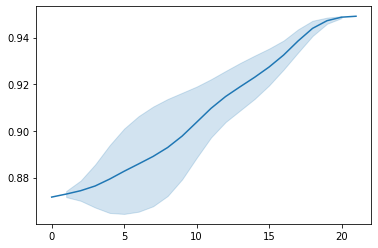

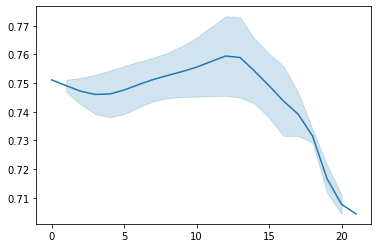

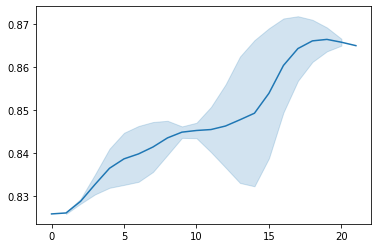

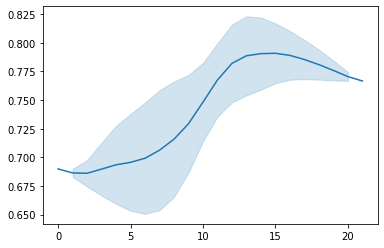

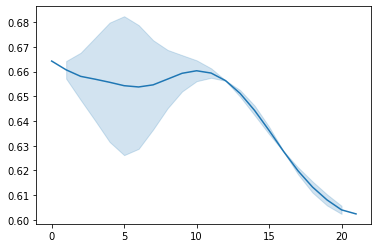

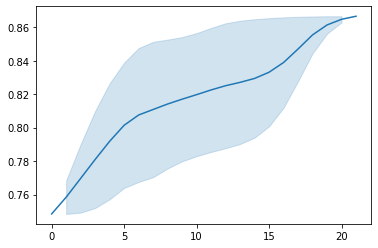

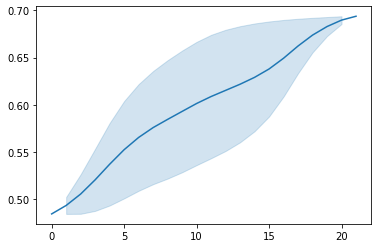

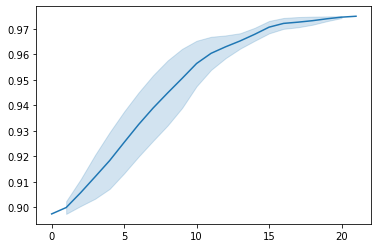

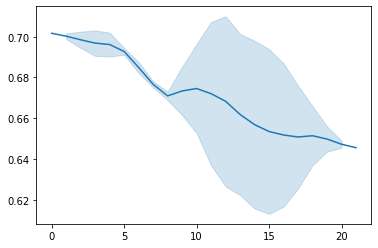

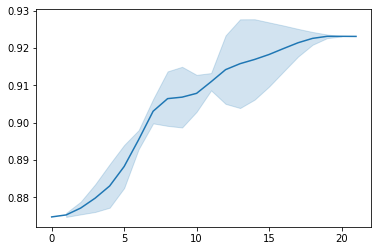

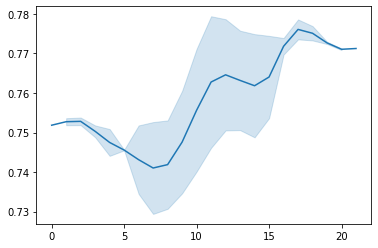

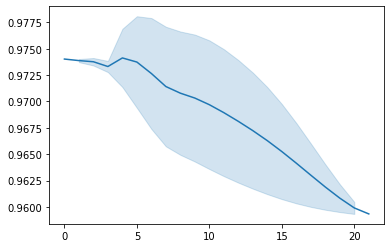

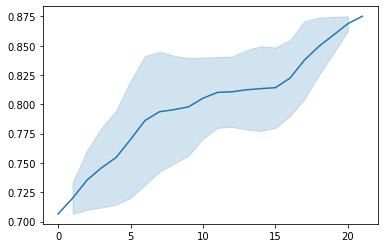

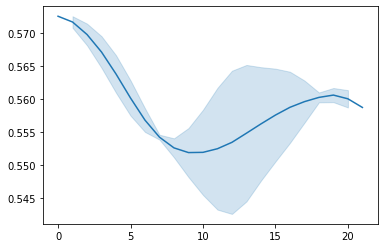

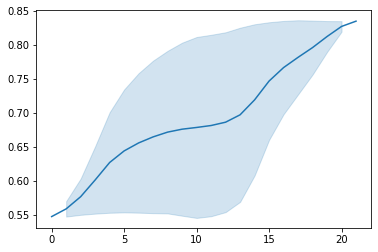

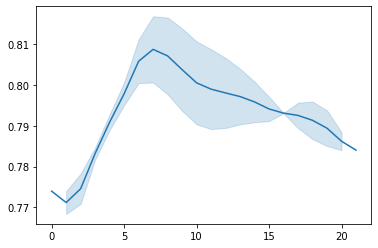

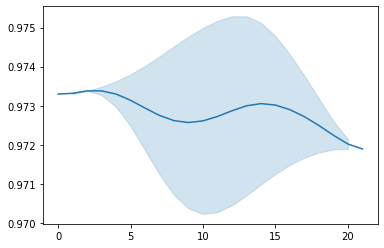

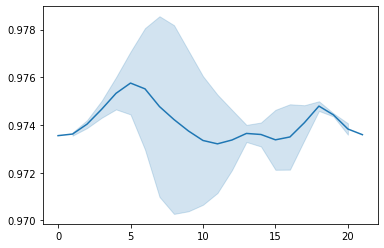

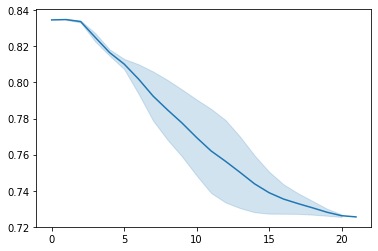

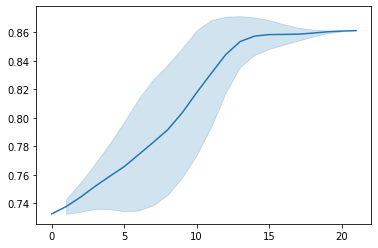

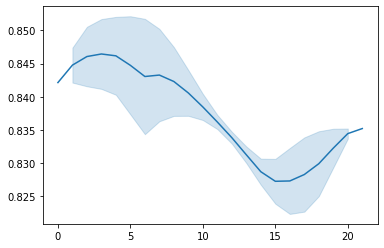

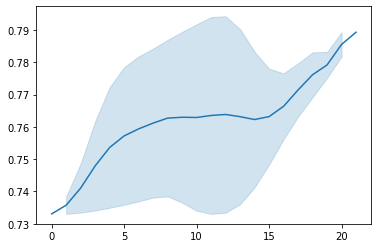

In [36]:
for lo_id in problems_dic.keys():
    preds = []
    for s in simu:
        res = predict_ks_from_history([{"lo_id": lo_id, "answer_result": a} for a in s])
        pred = [r['skill_pred'] for r in res if r['lo_id'] == lo_id]
        preds.append(*pred)
    sns.lineplot([sum(s) for s in simu], preds)
    plt.show()

### スケールを固定するバージョン

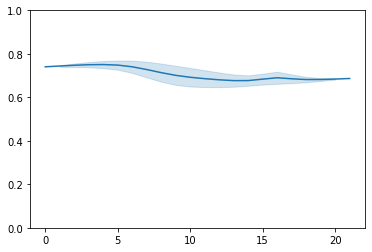

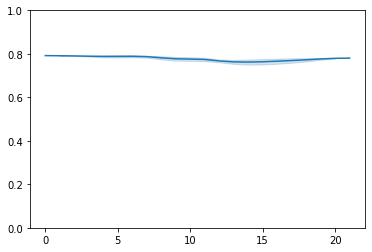

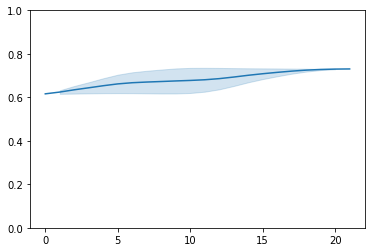

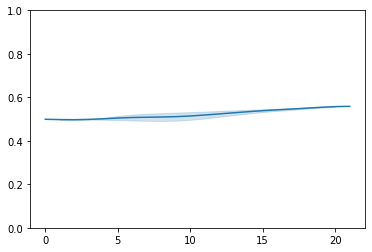

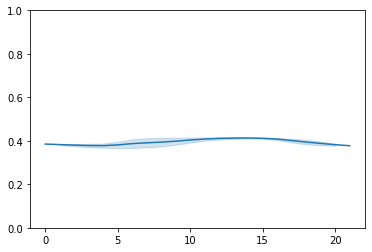

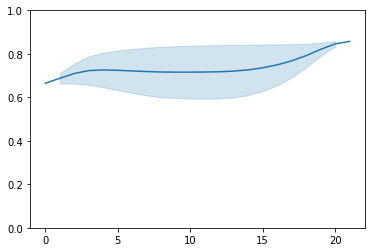

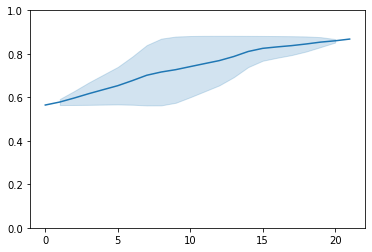

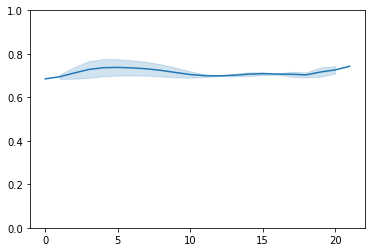

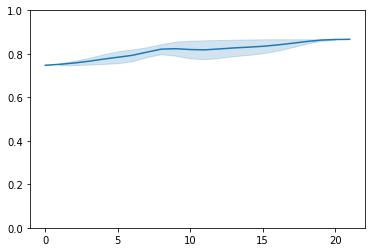

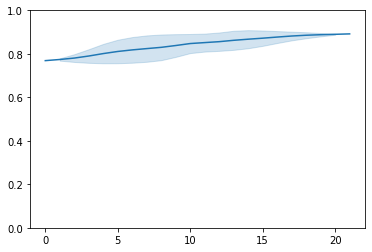

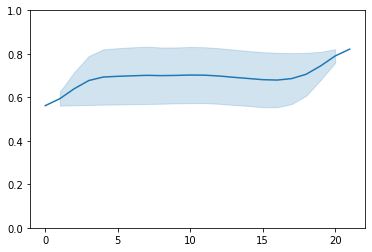

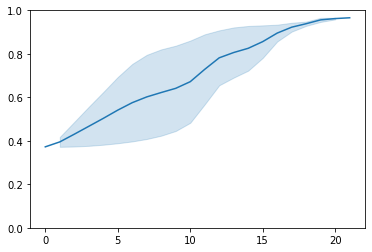

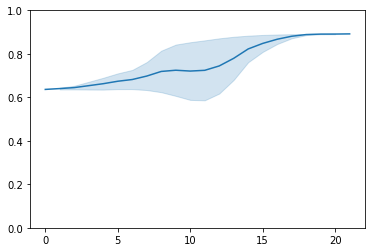

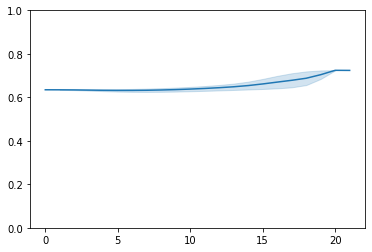

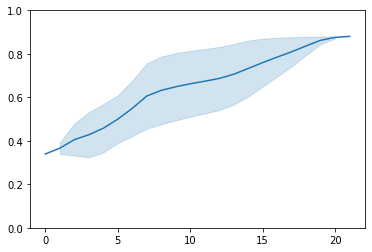

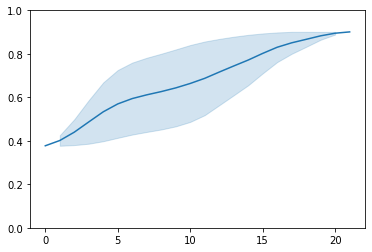

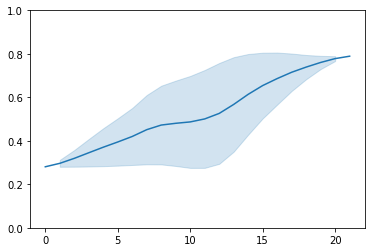

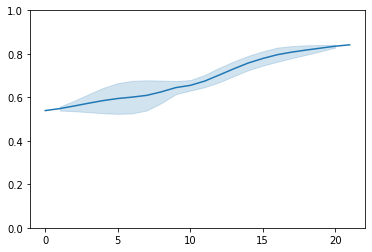

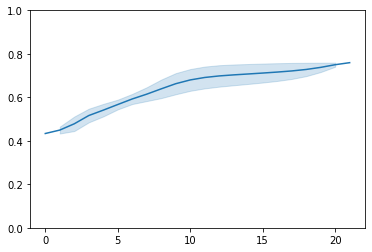

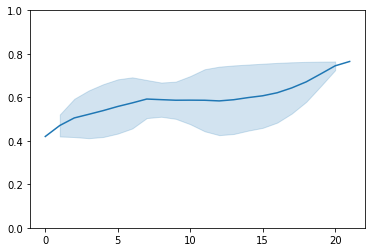

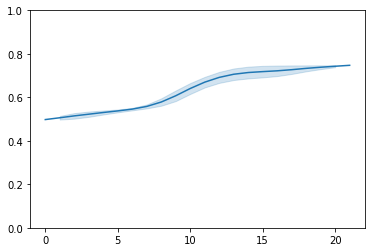

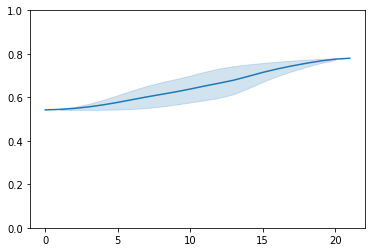

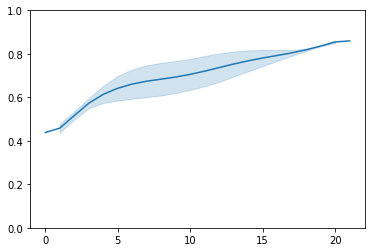

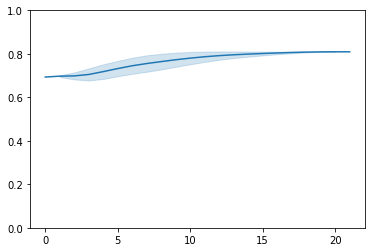

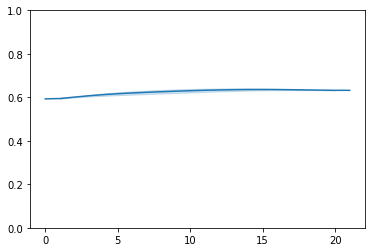

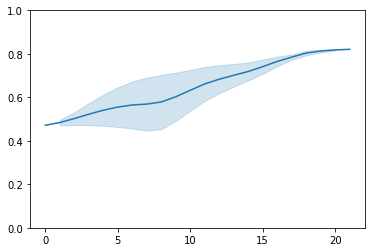

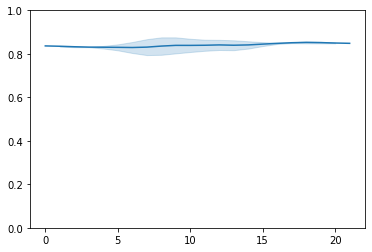

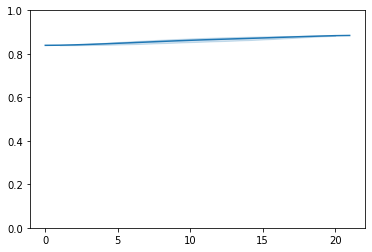

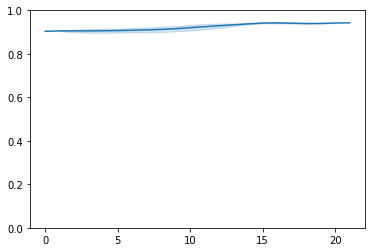

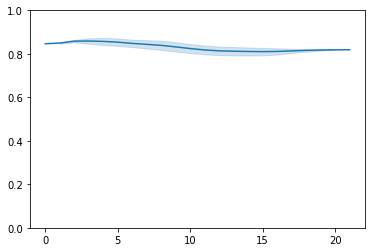

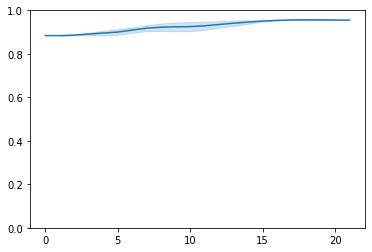

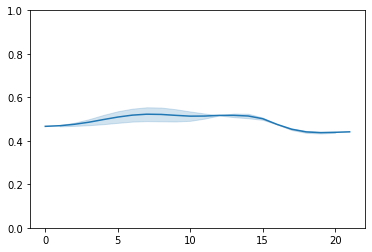

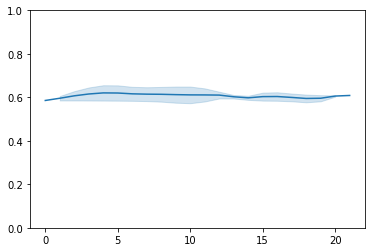

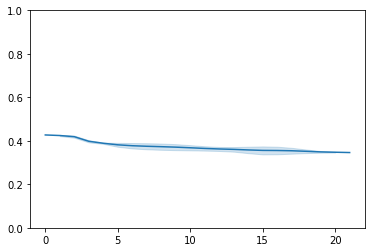

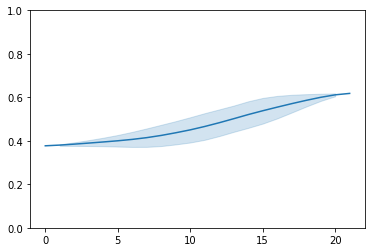

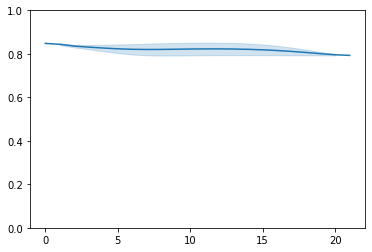

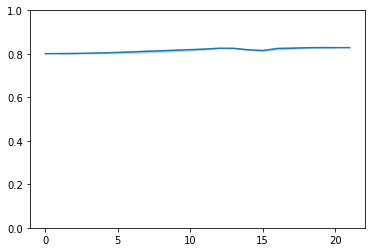

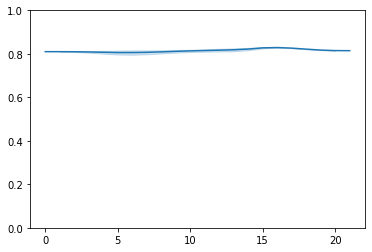

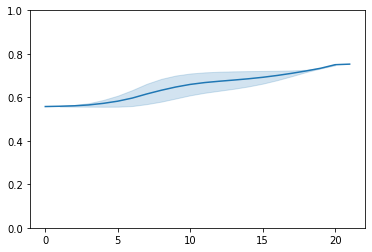

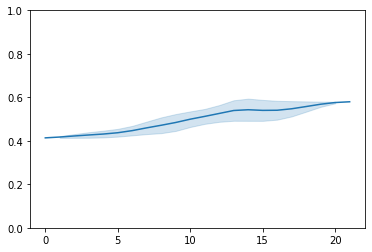

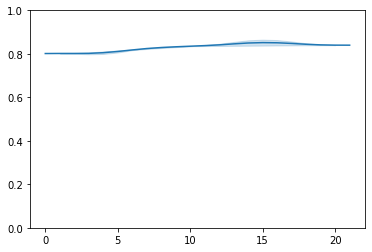

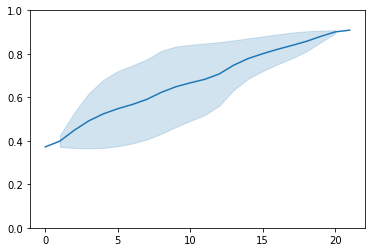

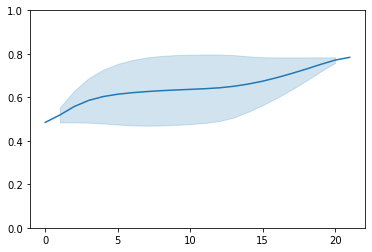

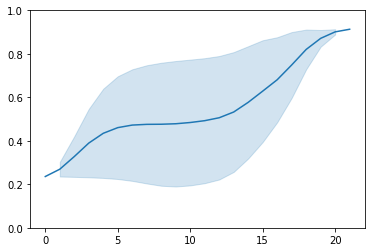

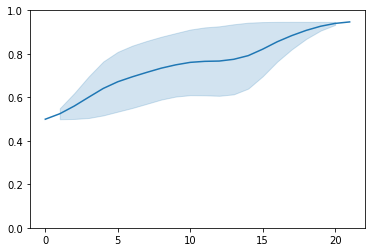

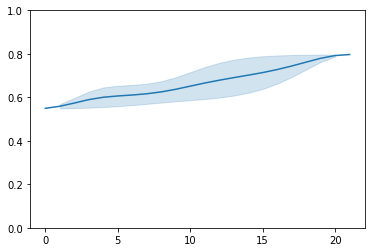

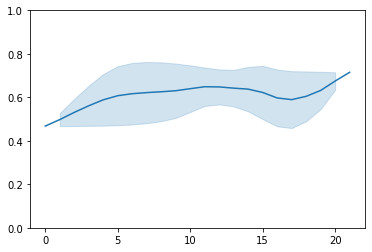

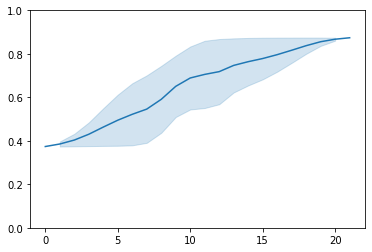

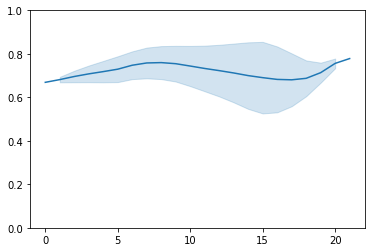

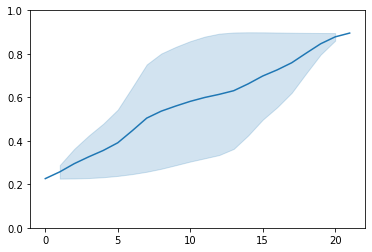

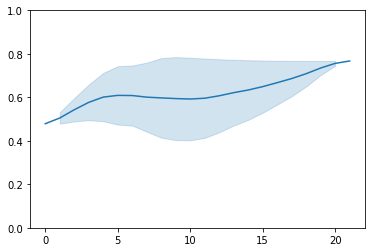

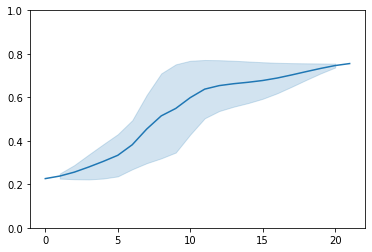

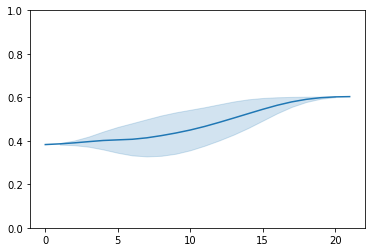

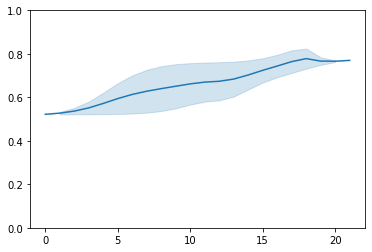

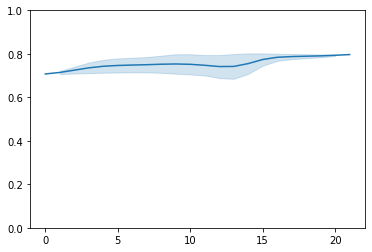

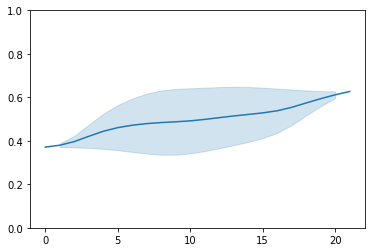

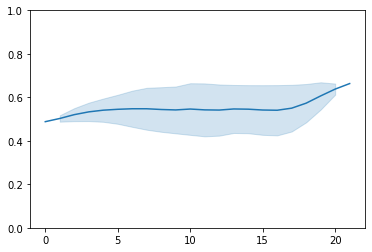

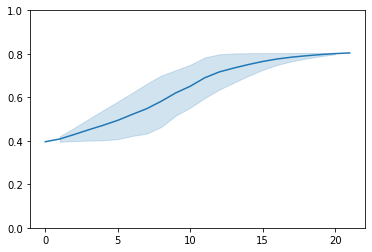

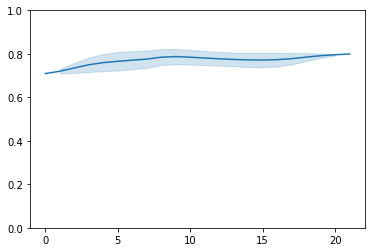

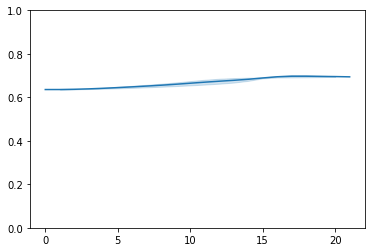

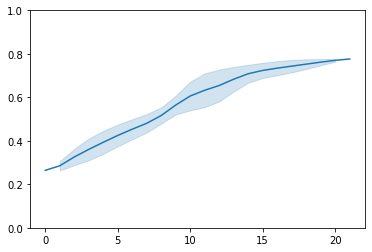

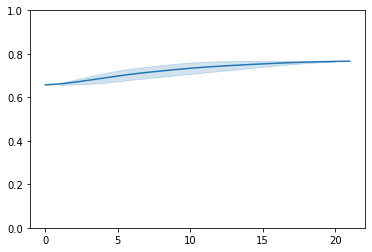

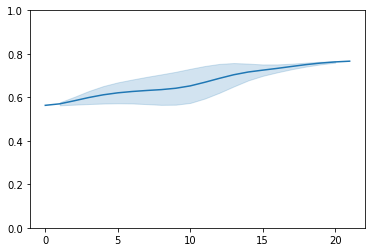

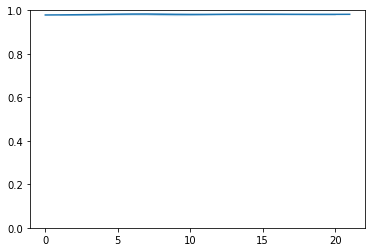

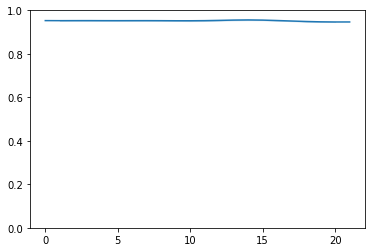

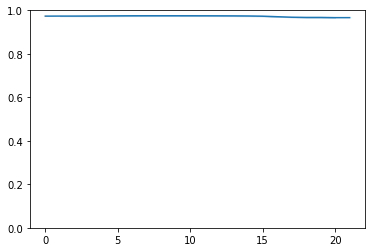

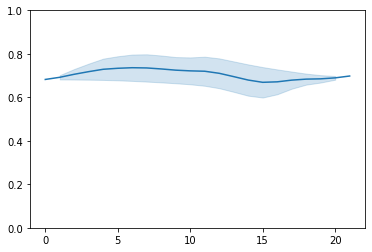

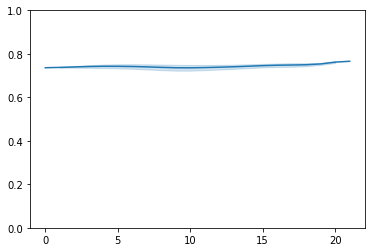

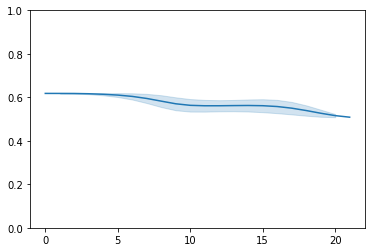

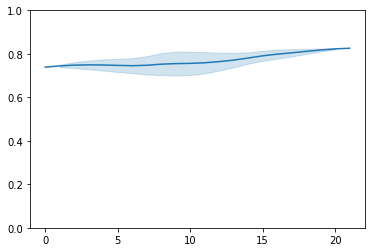

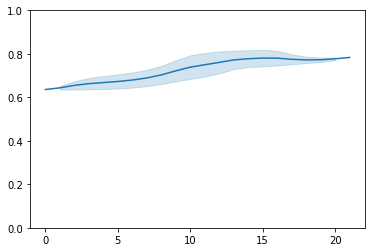

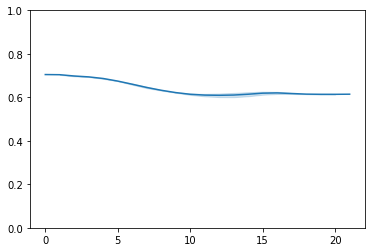

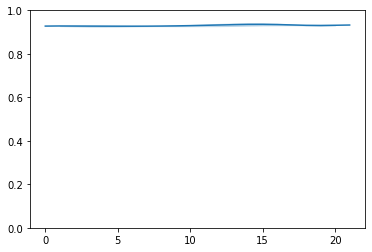

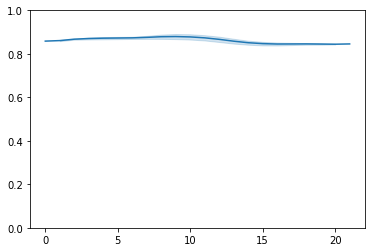

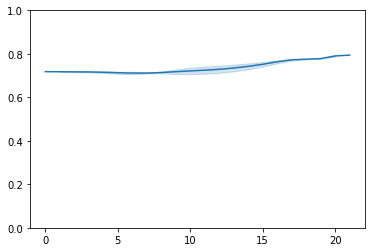

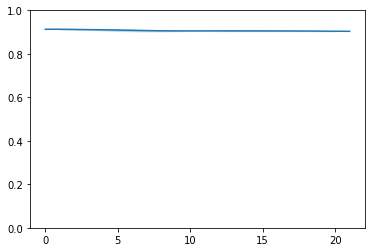

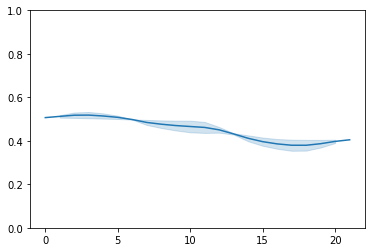

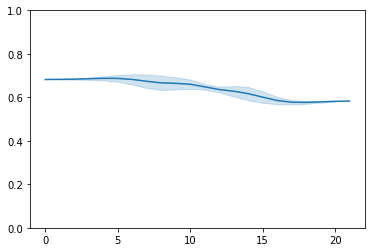

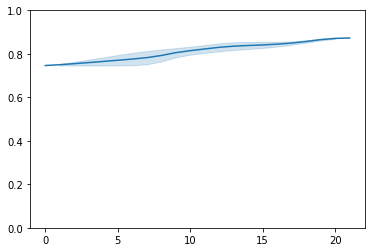

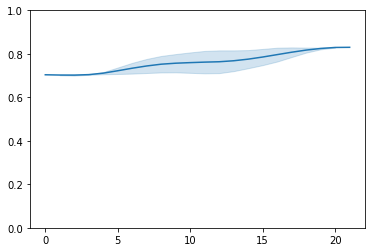

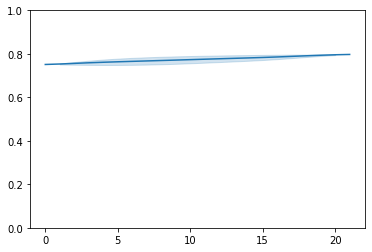

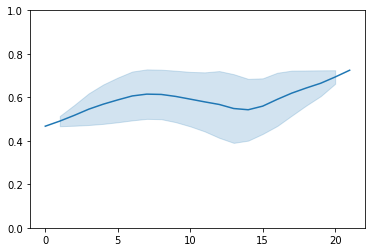

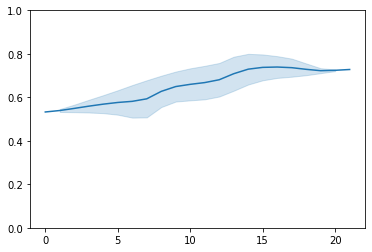

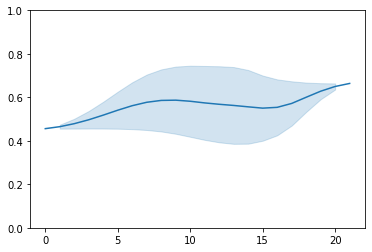

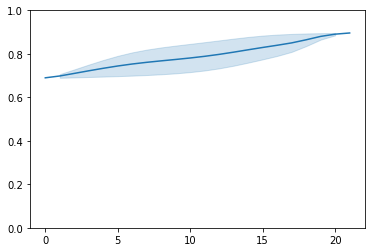

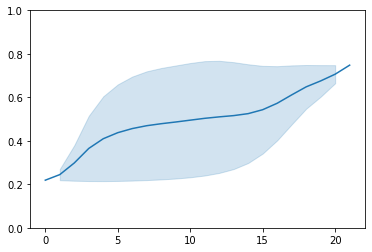

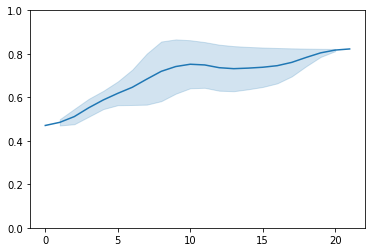

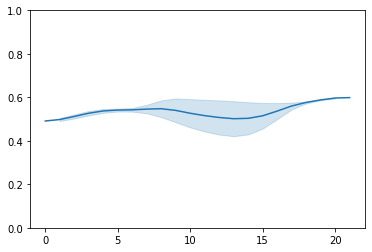

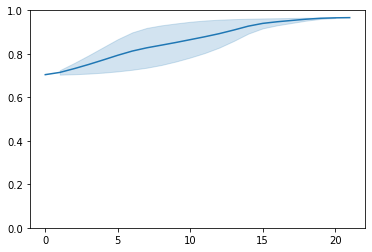

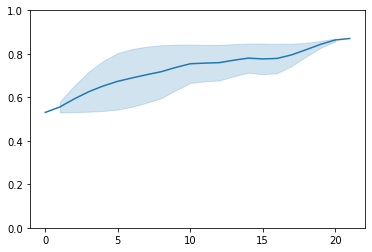

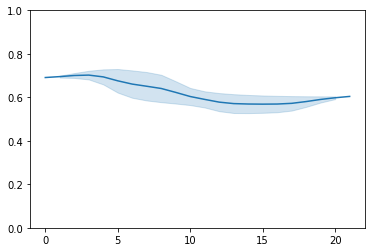

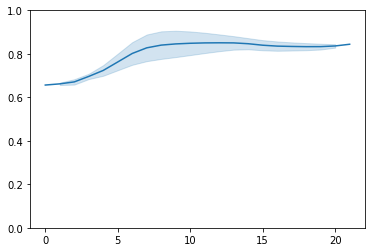

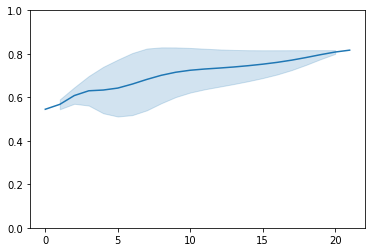

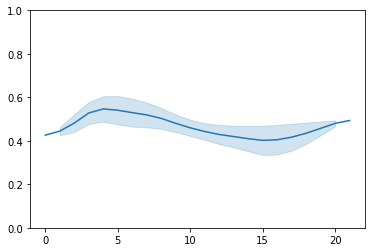

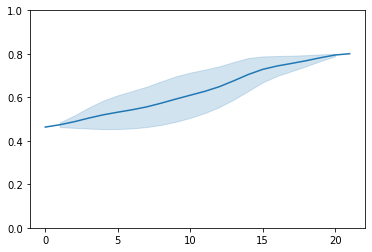

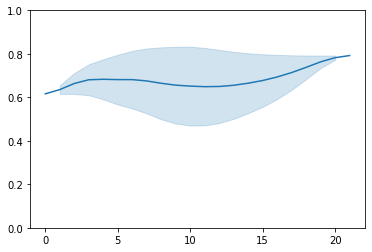

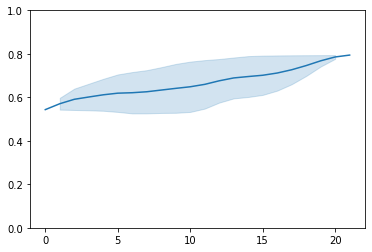

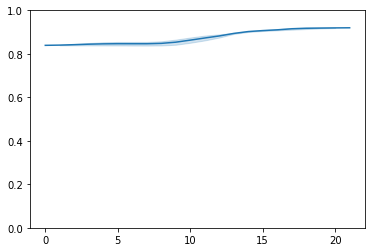

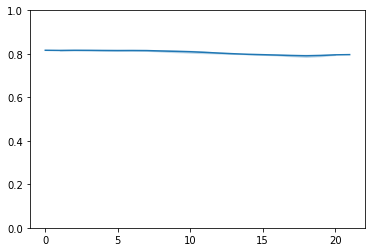

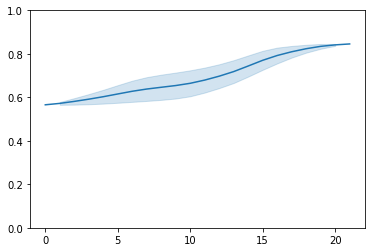

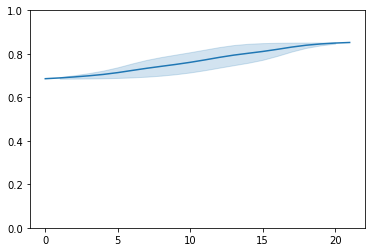

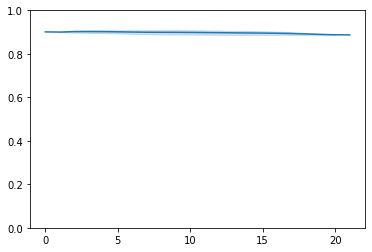

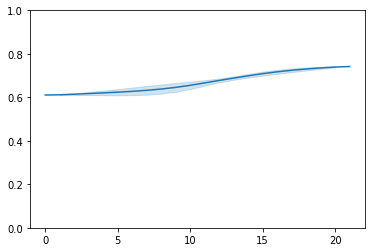

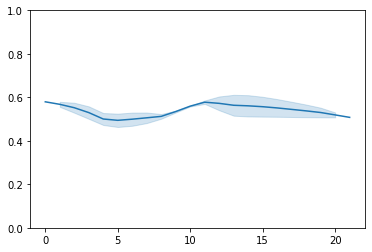

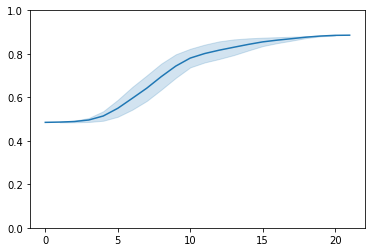

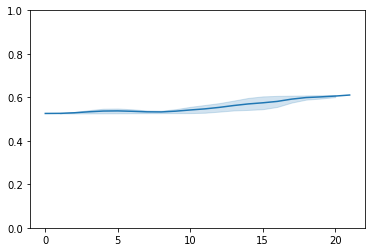

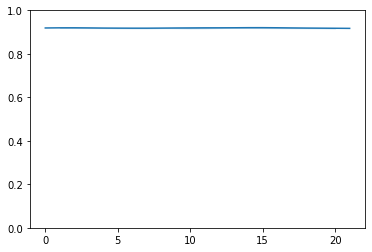

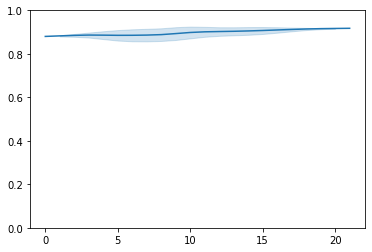

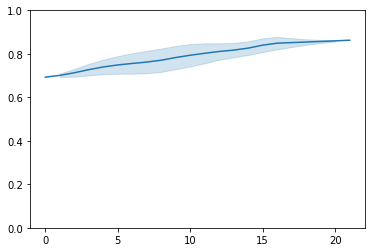

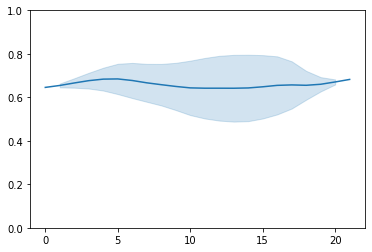

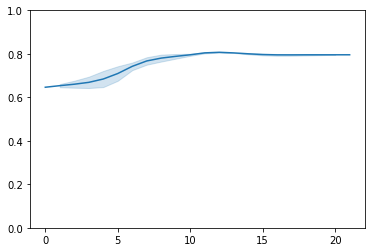

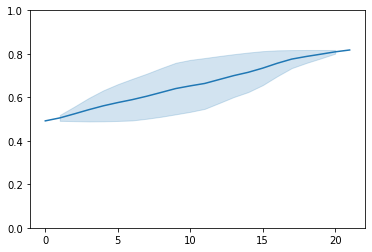

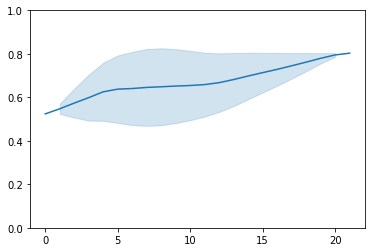

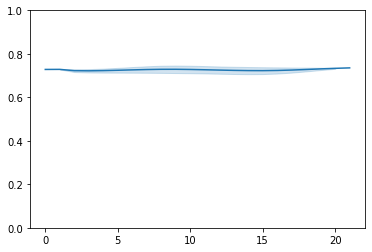

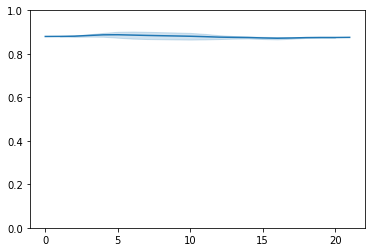

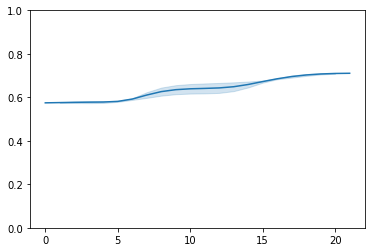

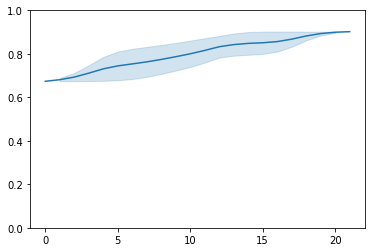

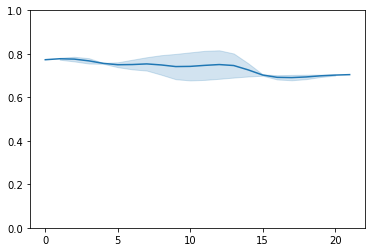

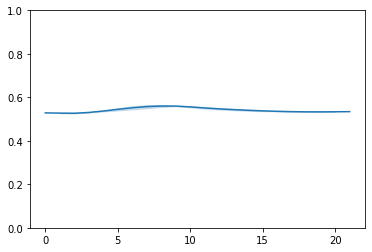

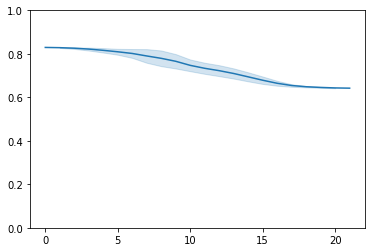

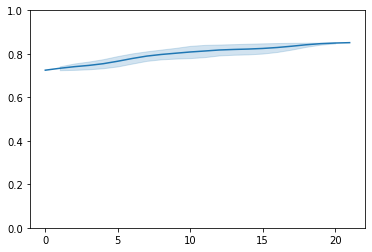

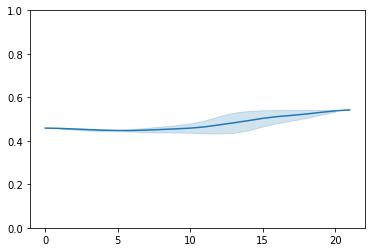

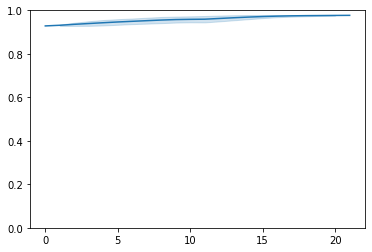

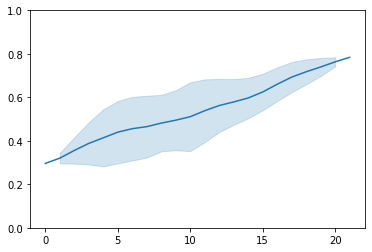

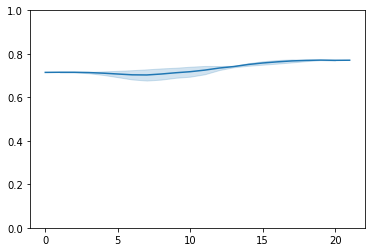

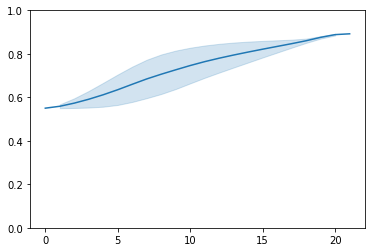

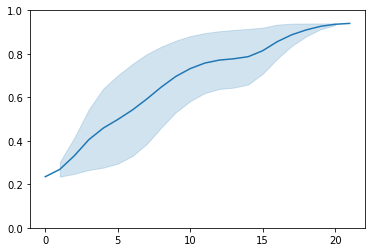

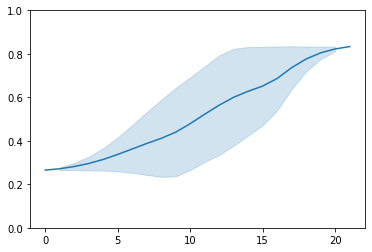

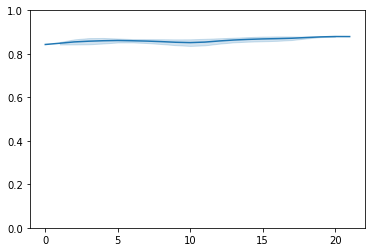

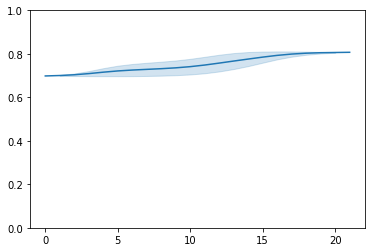

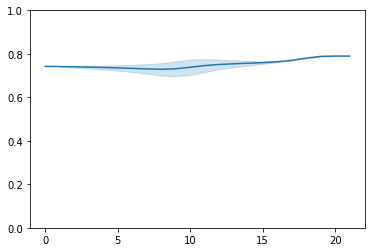

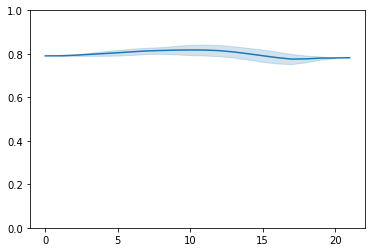

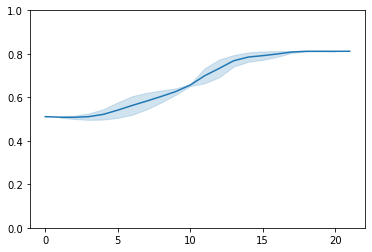

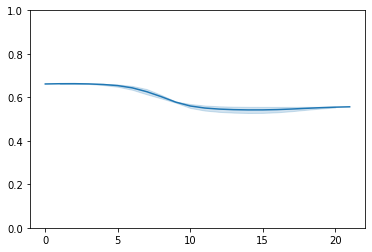

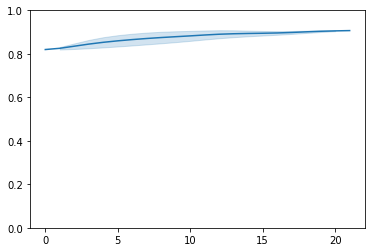

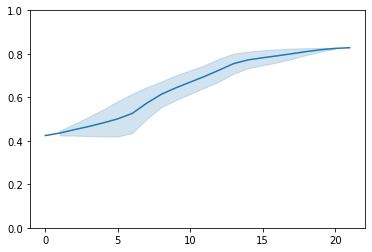

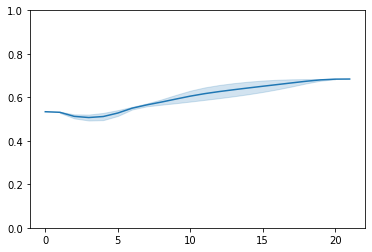

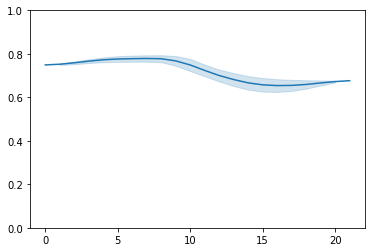

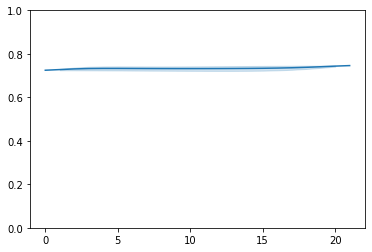

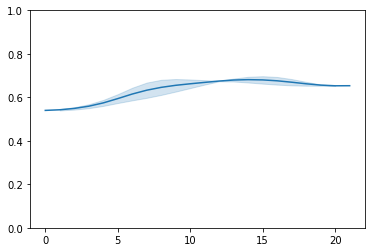

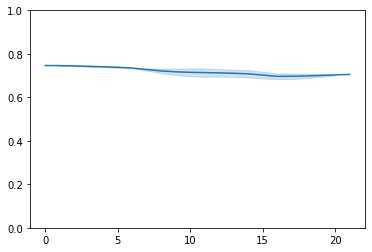

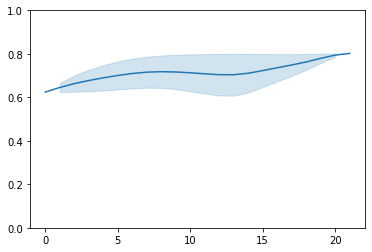

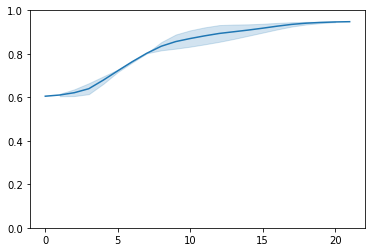

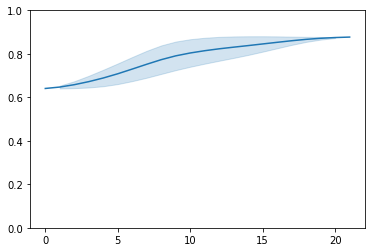

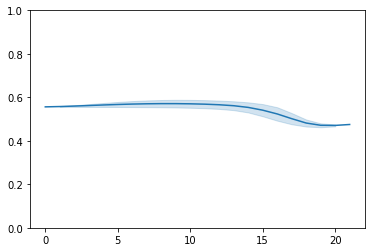

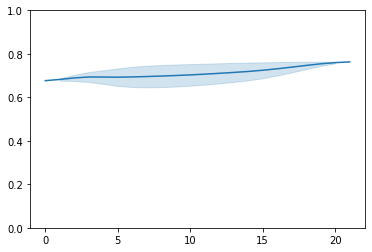

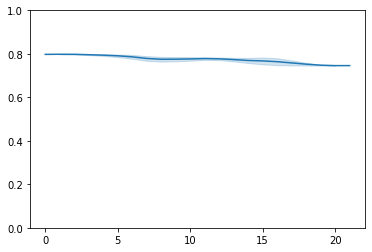

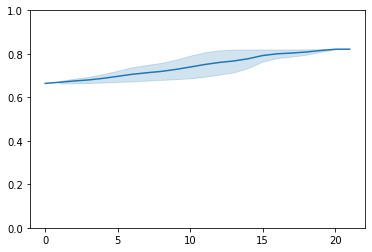

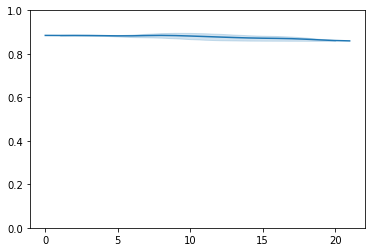

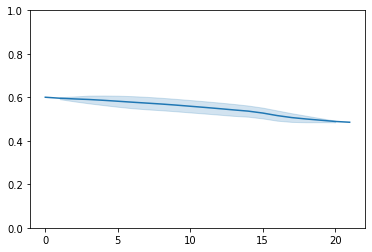

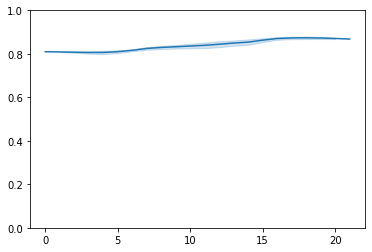

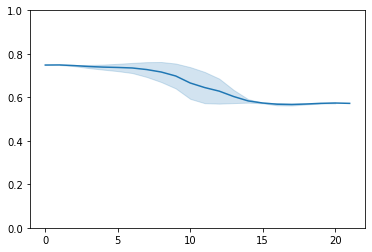

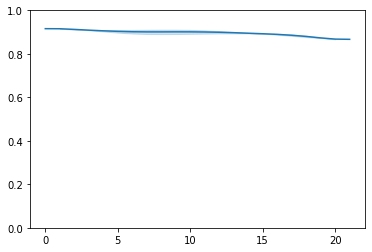

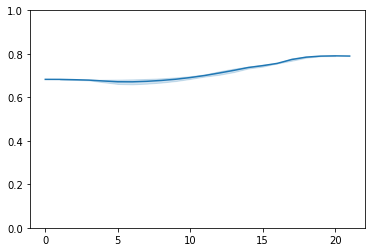

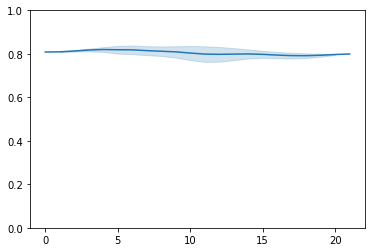

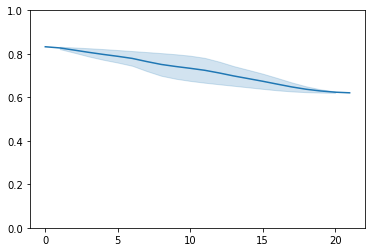

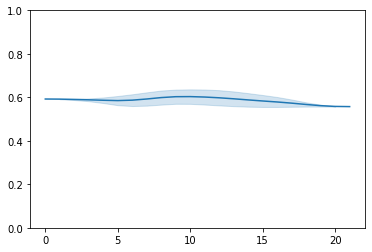

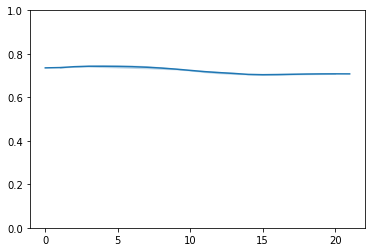

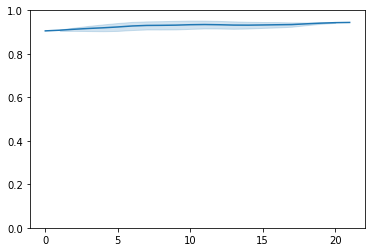

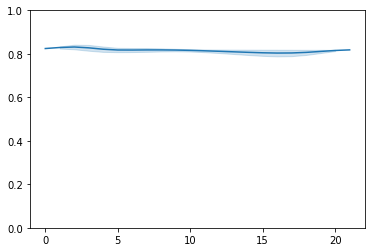

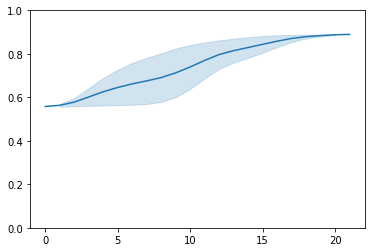

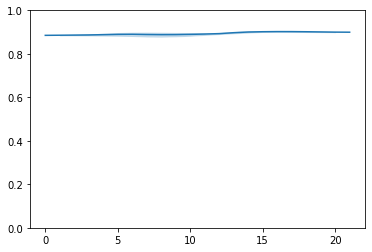

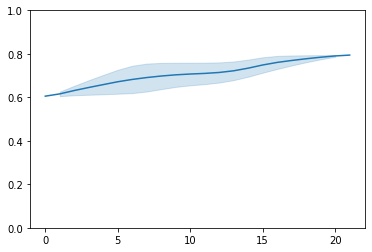

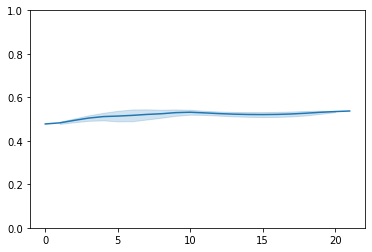

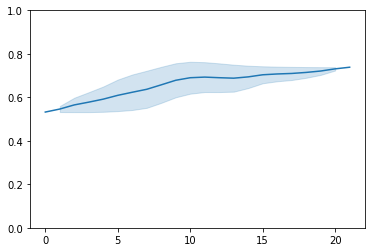

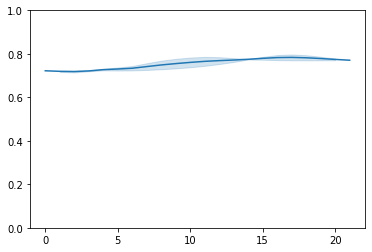

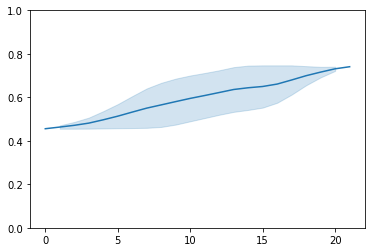

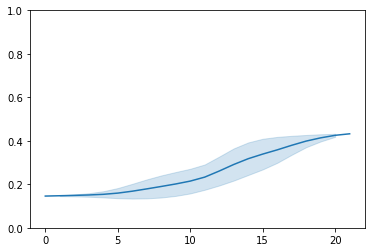

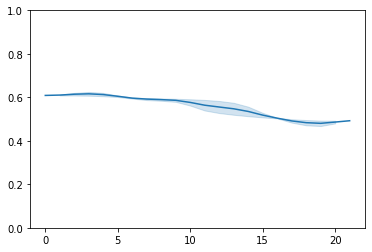

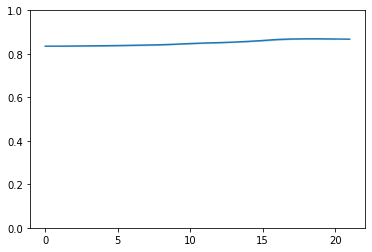

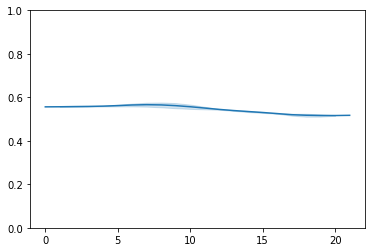

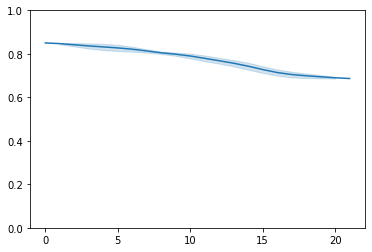

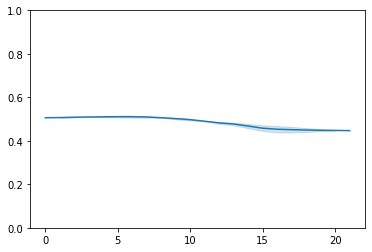

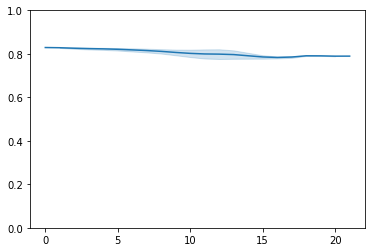

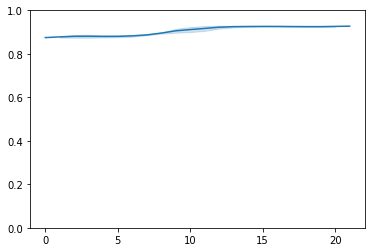

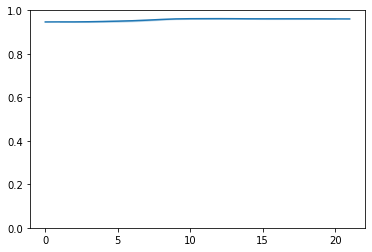

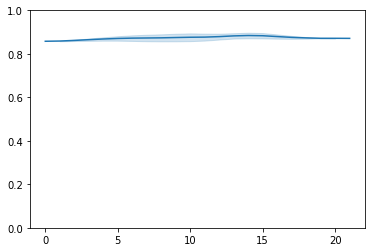

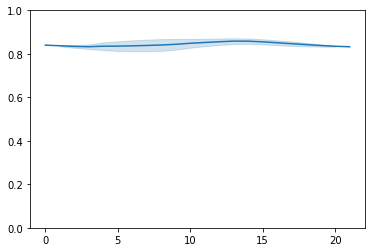

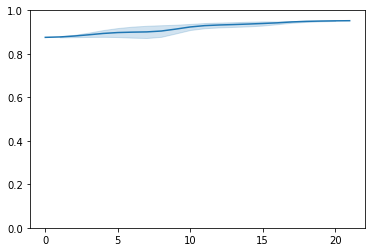

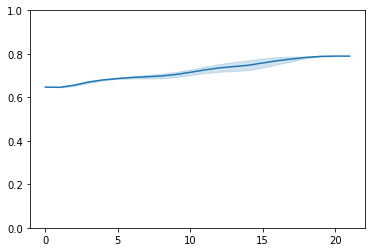

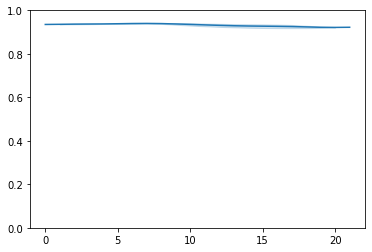

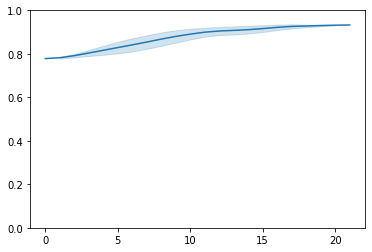

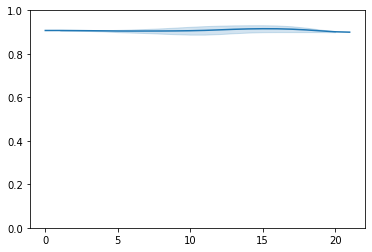

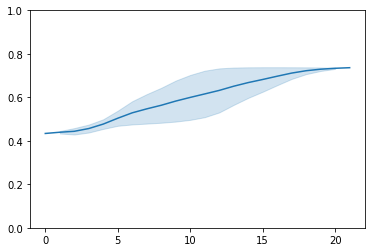

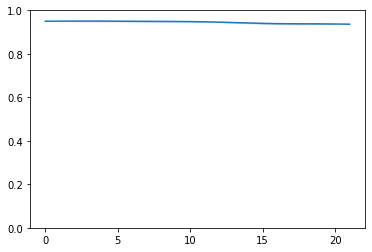

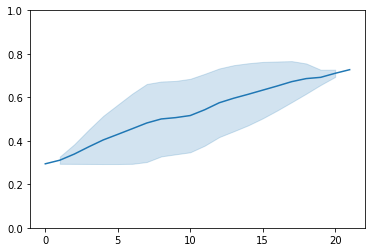

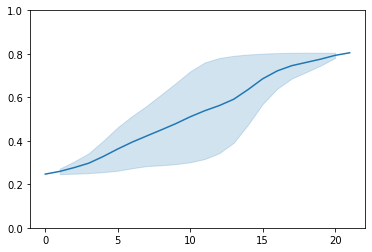

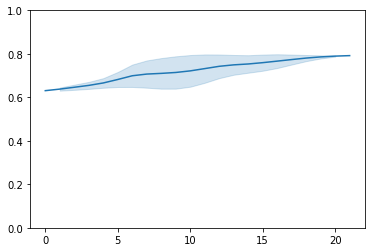

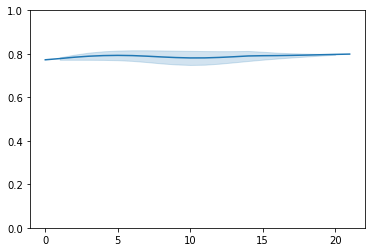

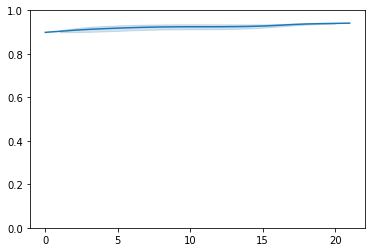

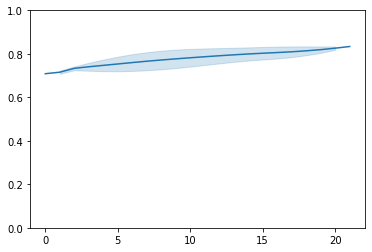

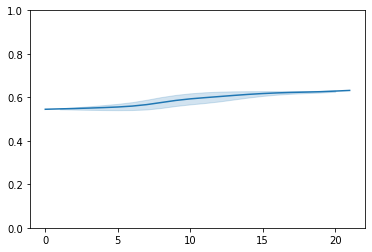

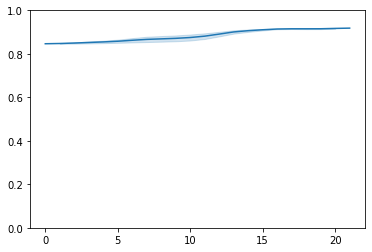

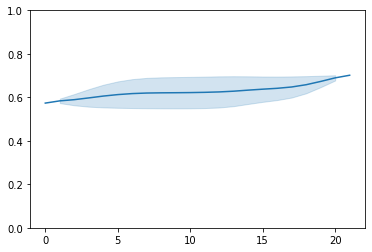

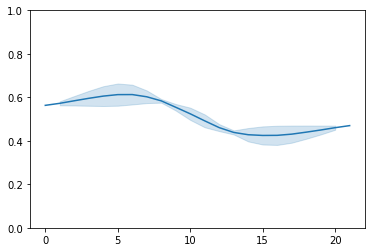

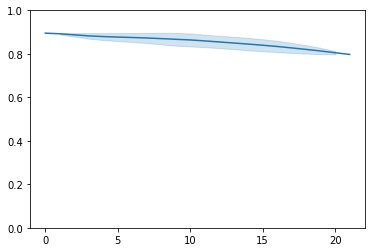

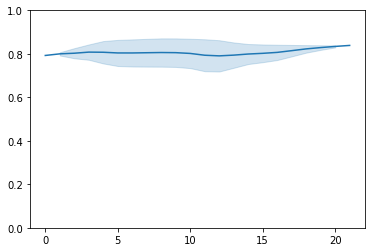

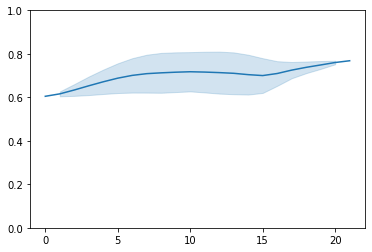

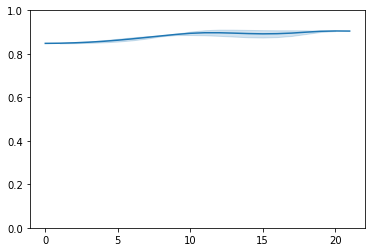

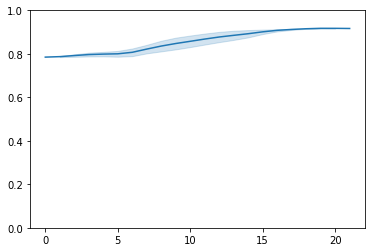

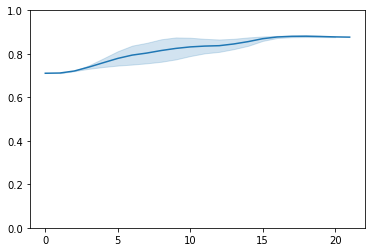

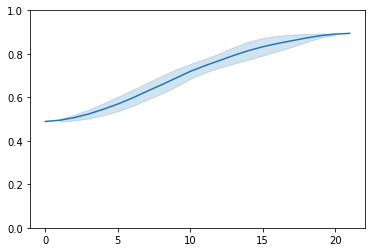

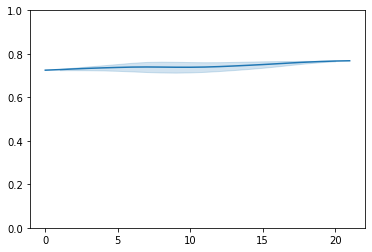

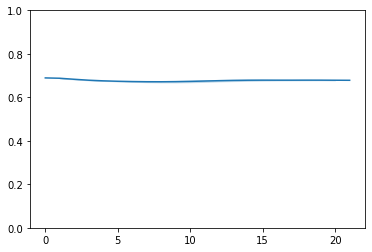

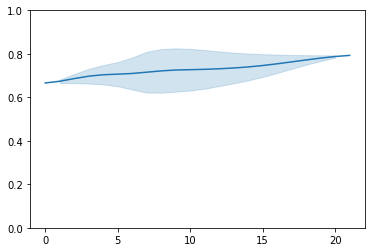

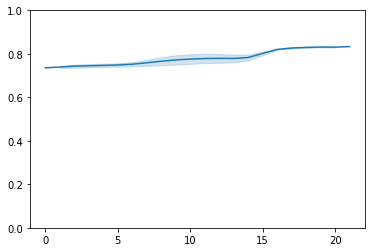

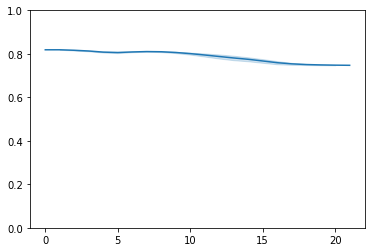

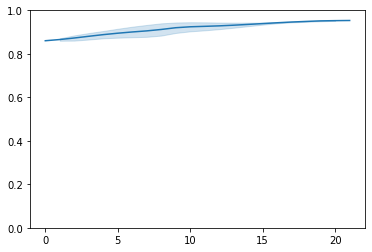

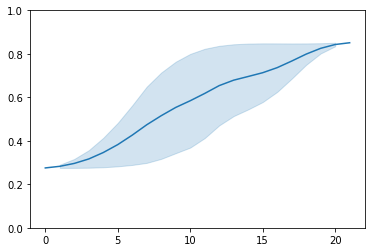

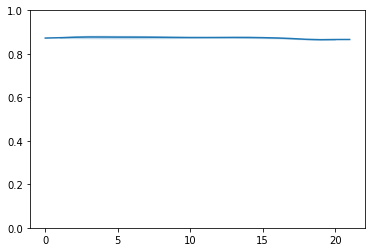

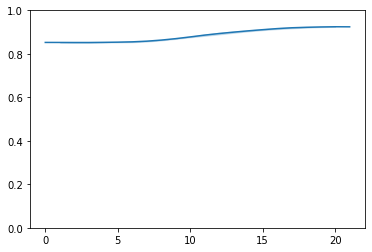

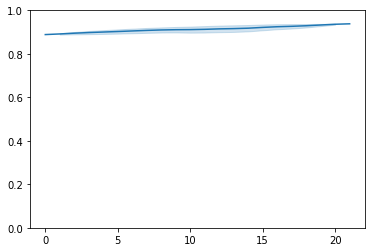

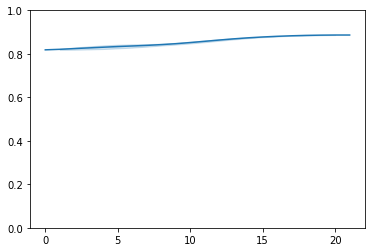

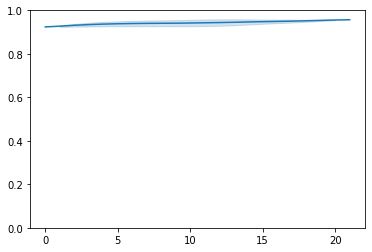

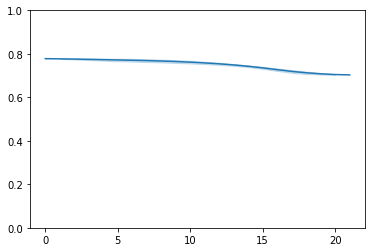

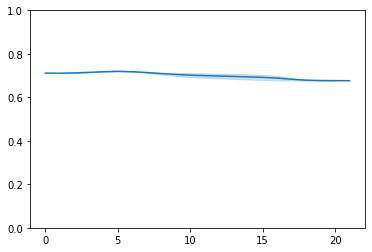

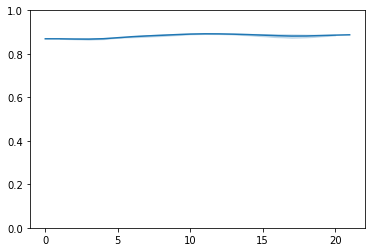

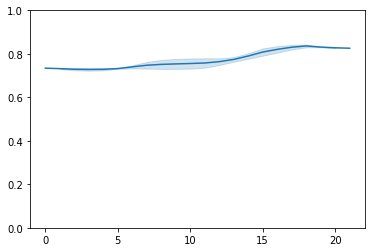

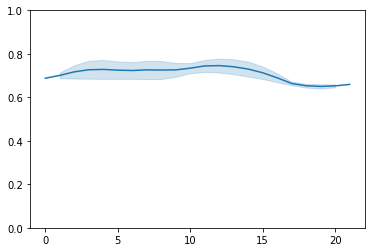

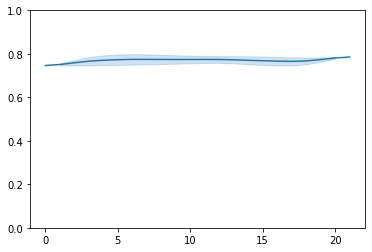

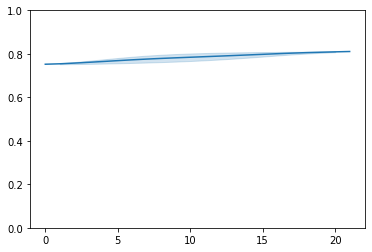

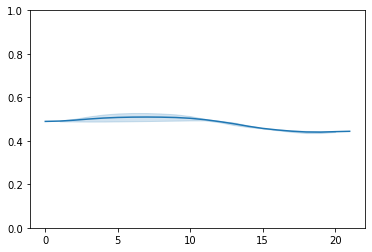

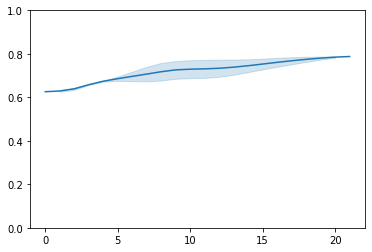

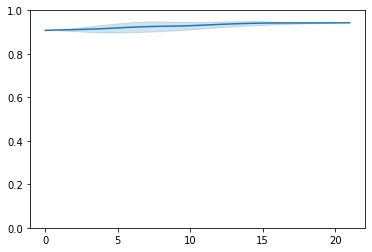

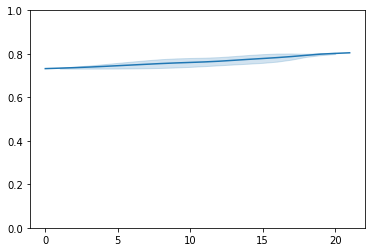

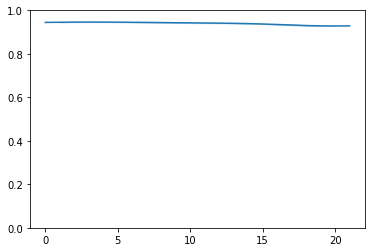

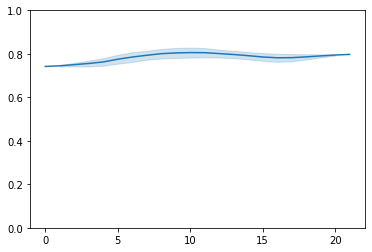

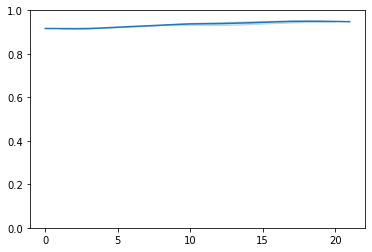

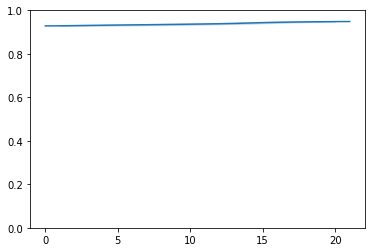

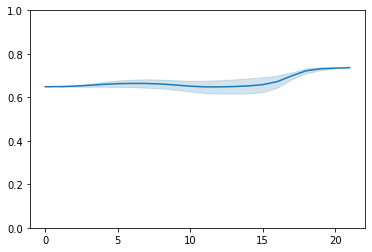

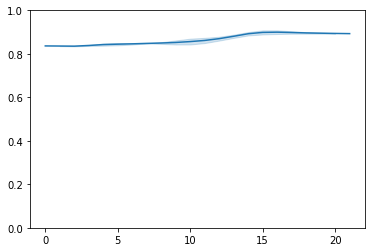

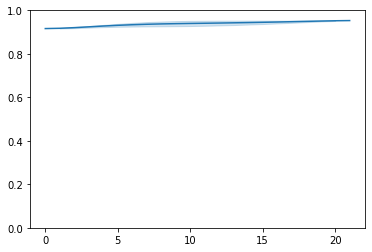

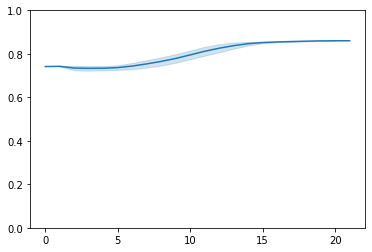

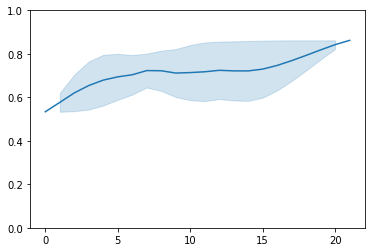

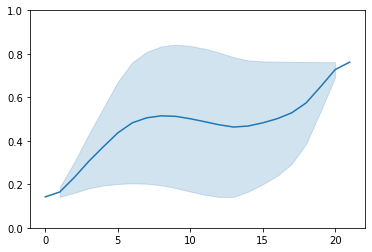

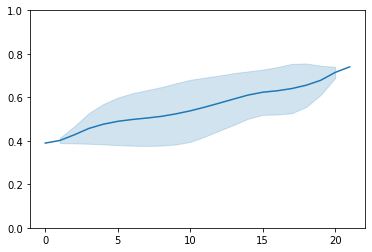

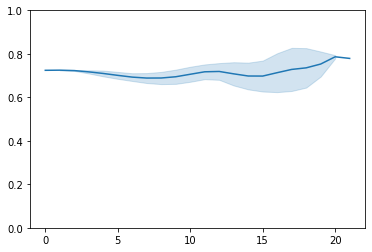

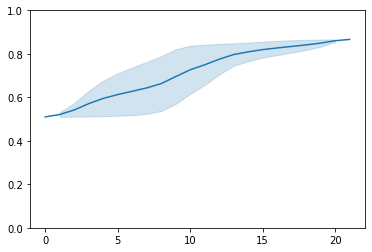

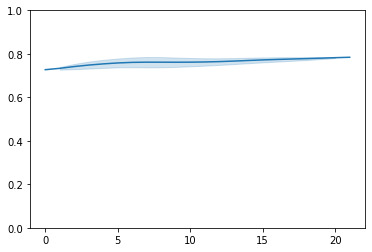

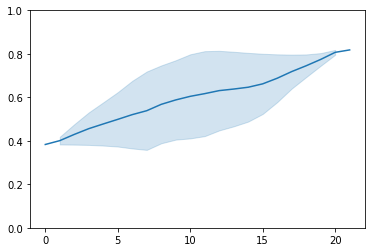

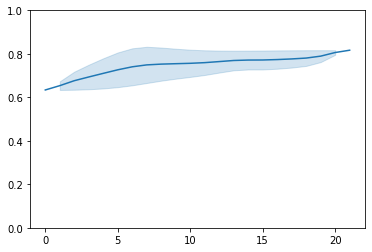

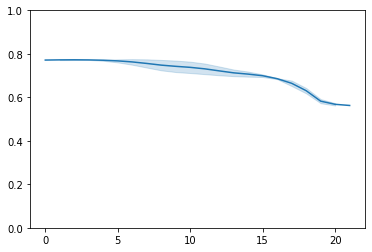

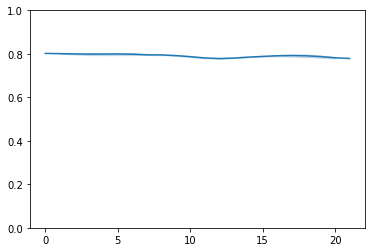

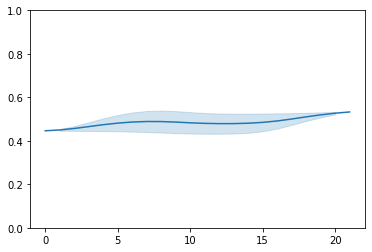

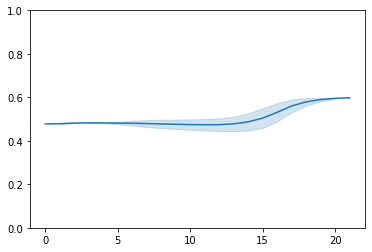

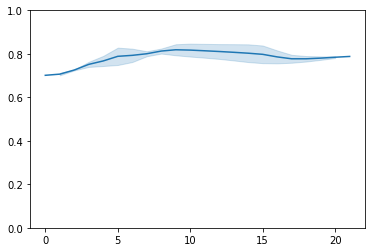

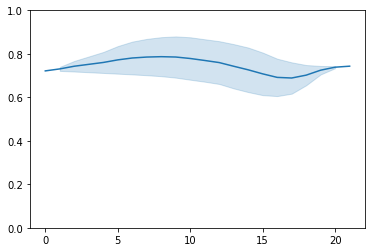

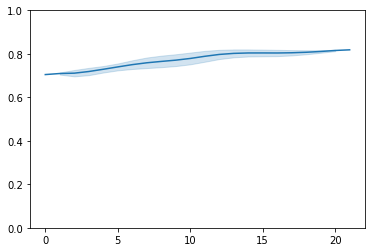

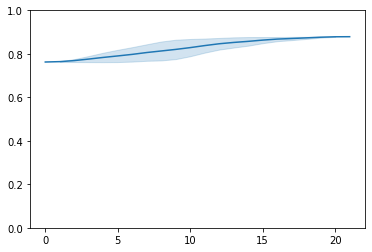

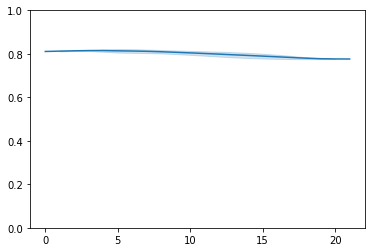

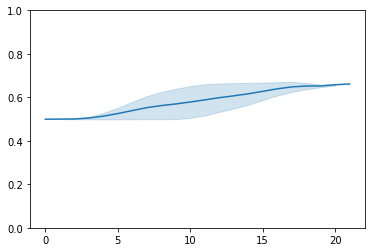

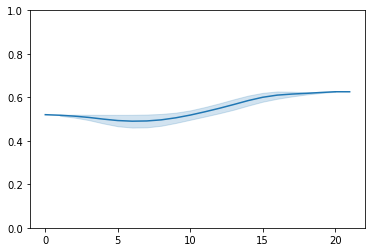

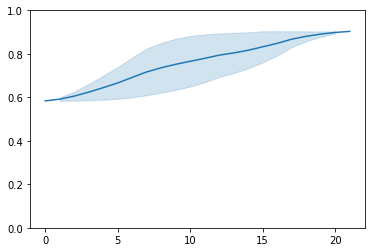

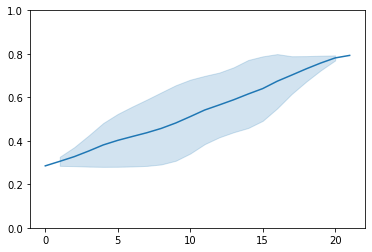

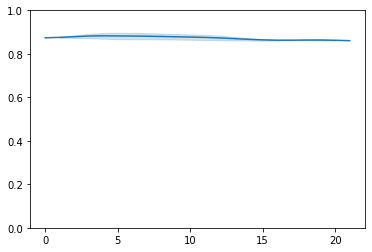

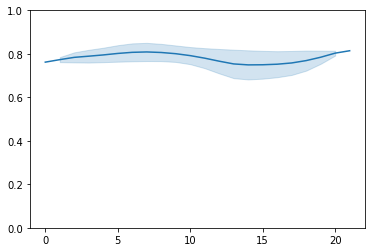

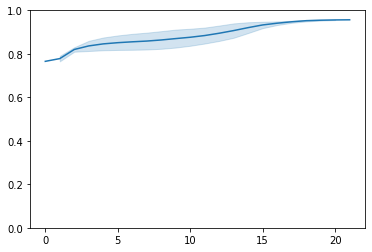

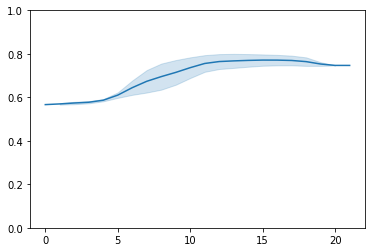

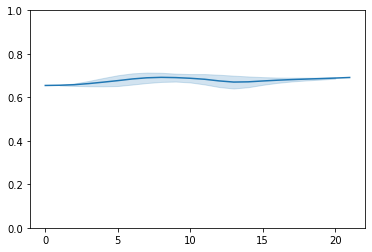

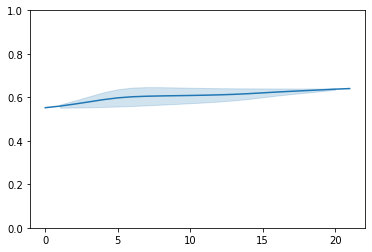

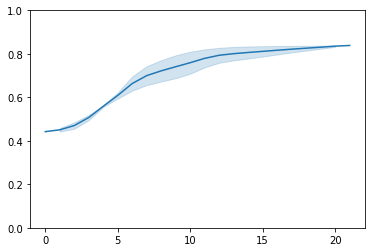

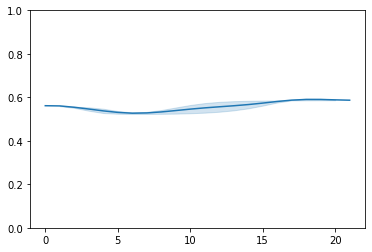

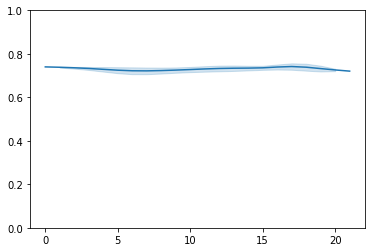

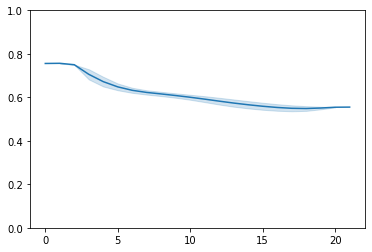

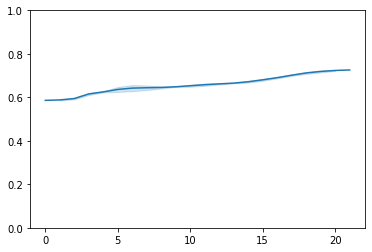

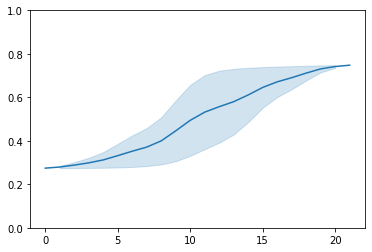

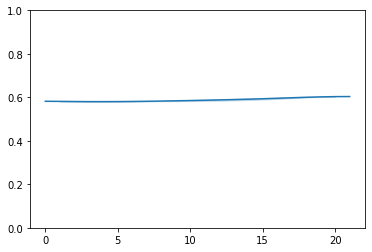

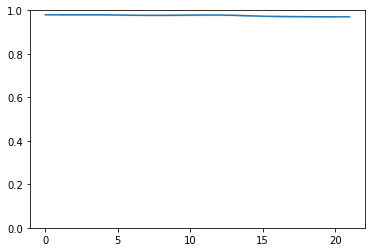

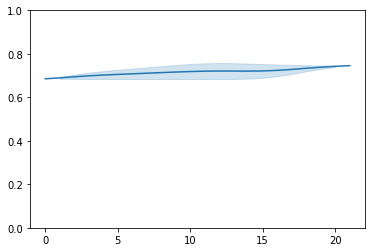

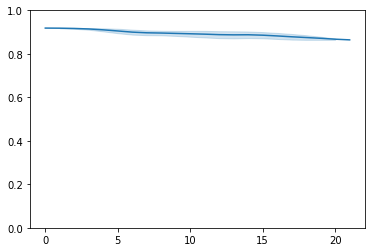

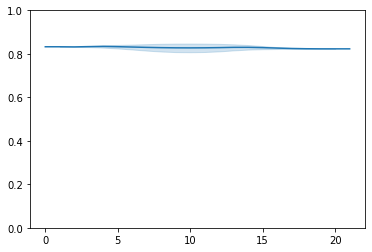

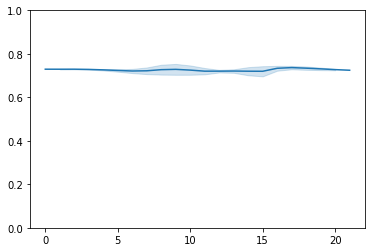

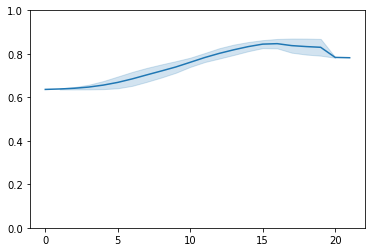

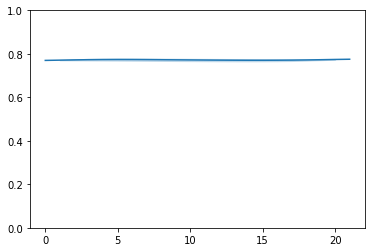

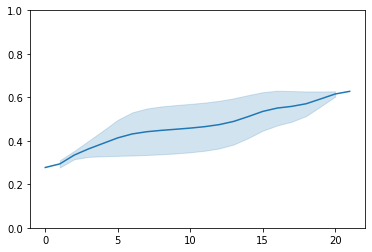

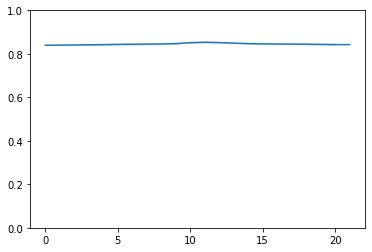

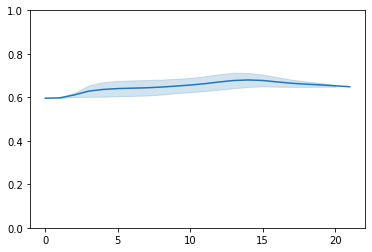

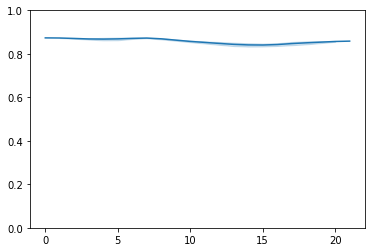

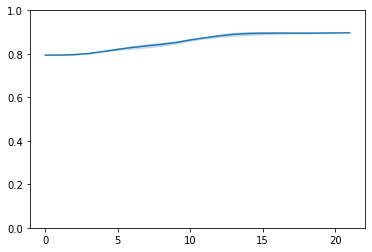

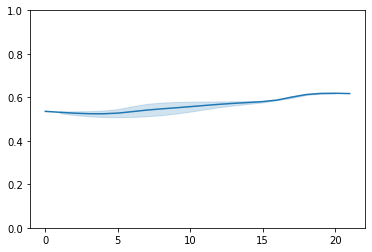

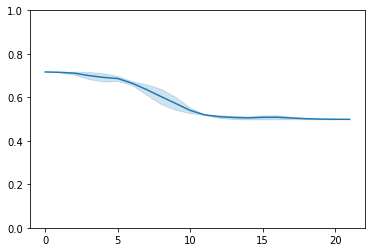

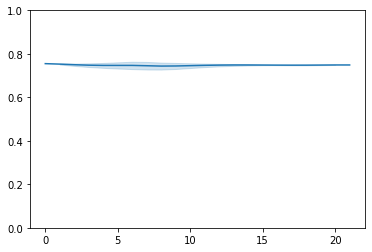

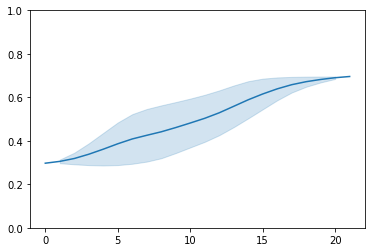

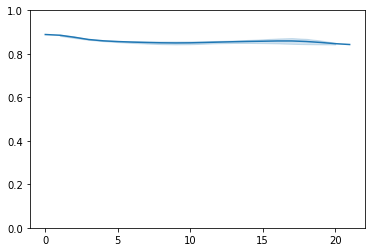

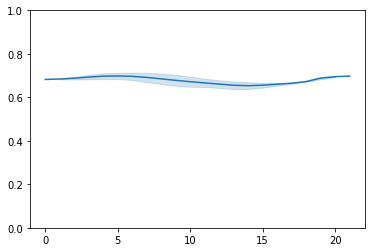

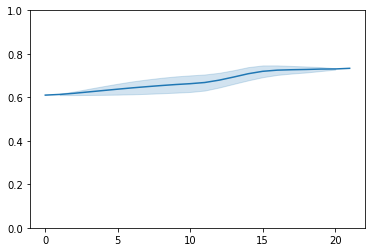

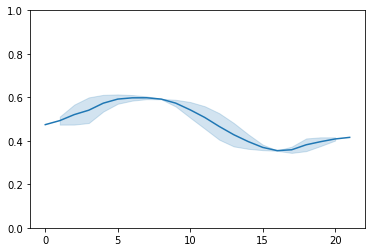

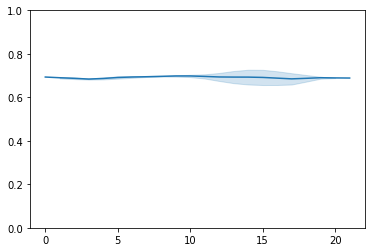

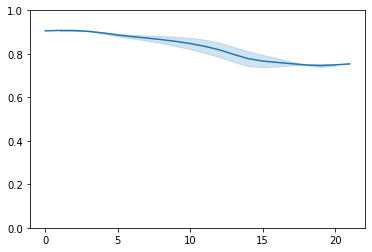

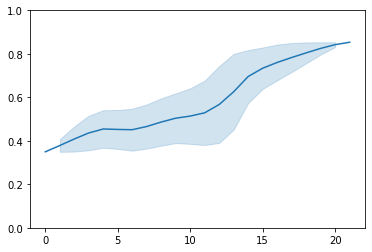

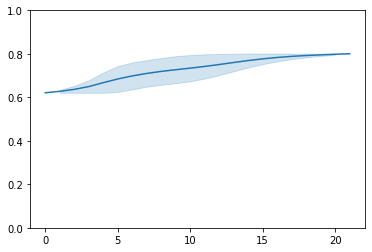

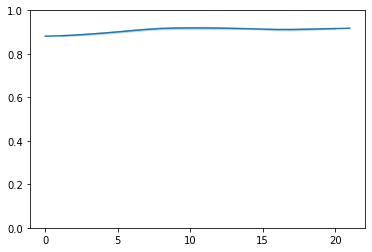

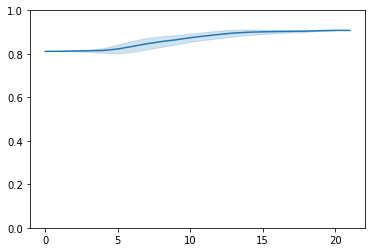

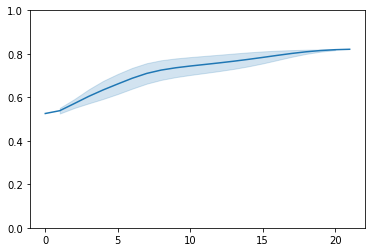

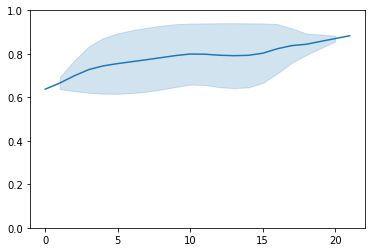

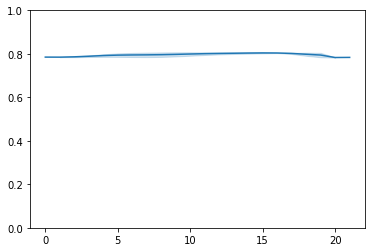

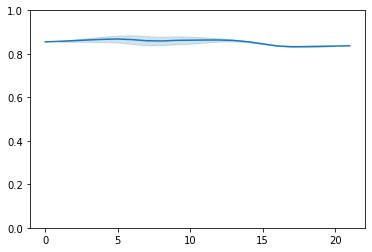

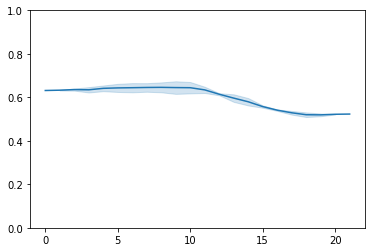

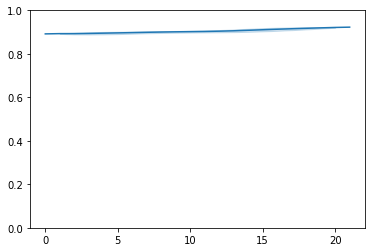

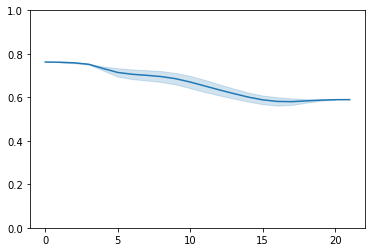

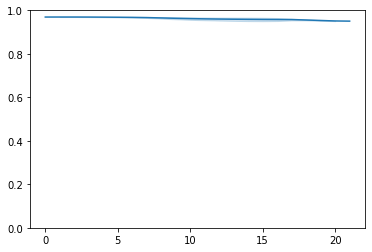

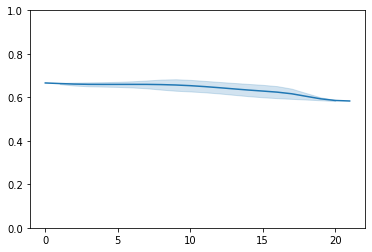

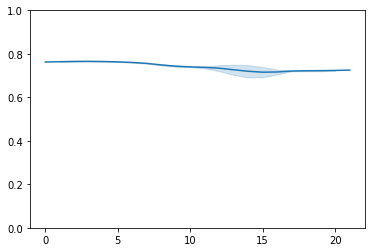

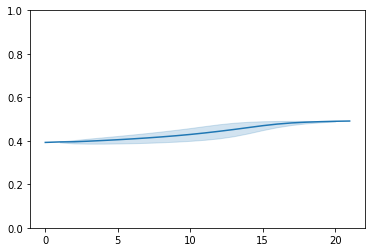

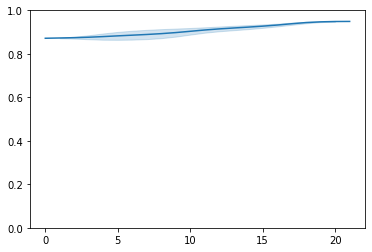

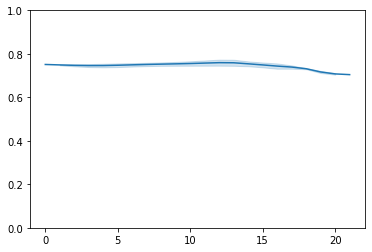

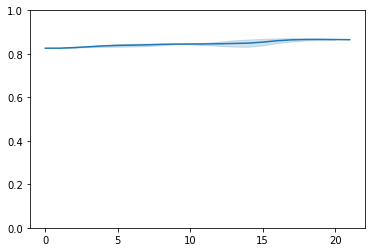

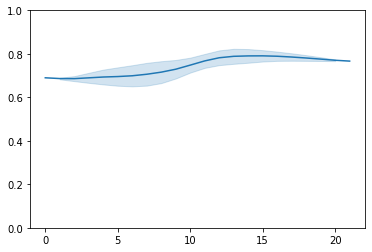

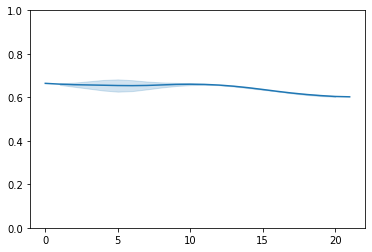

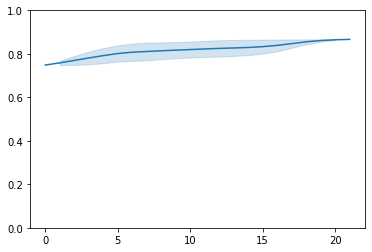

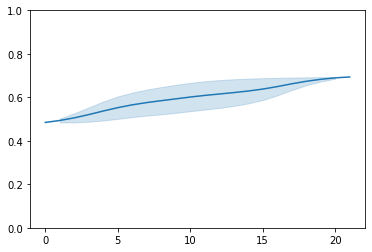

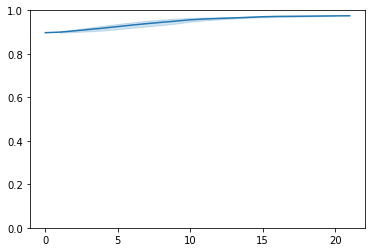

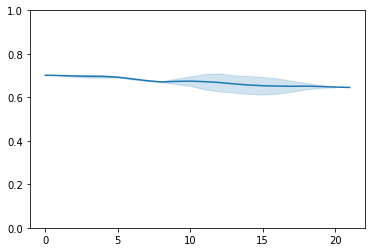

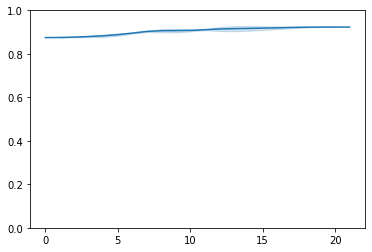

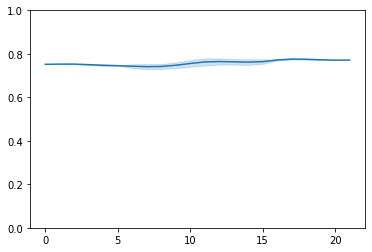

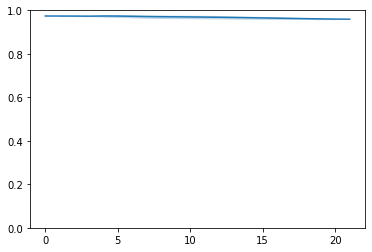

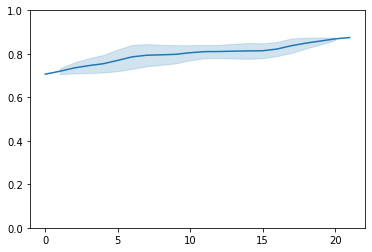

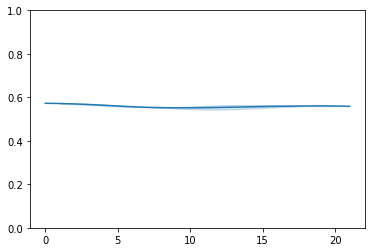

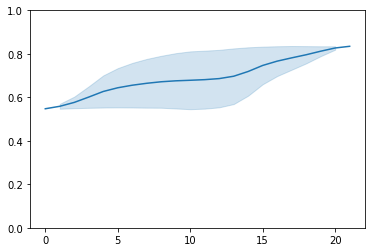

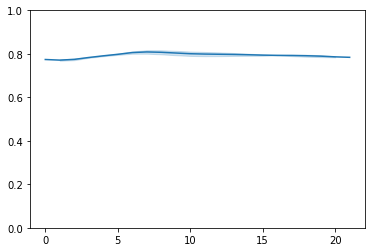

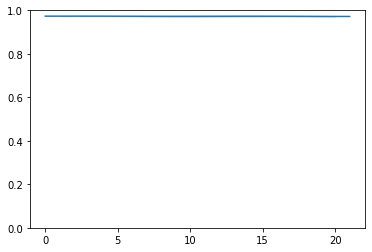

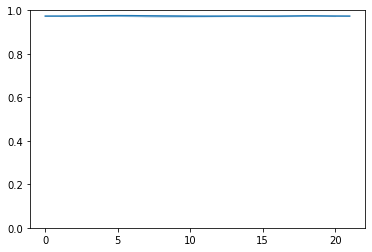

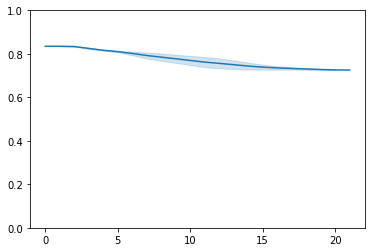

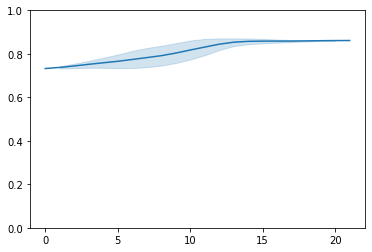

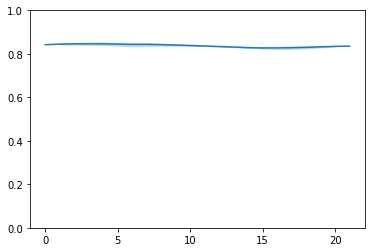

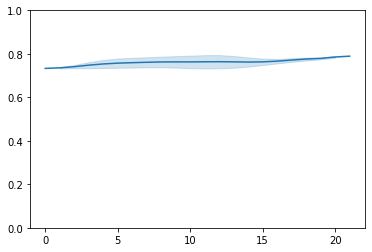

In [38]:
for lo_id in problems_dic.keys():
    preds = []
    for s in simu:
        res = predict_ks_from_history([{"lo_id": lo_id, "answer_result": a} for a in s])
        pred = [r['skill_pred'] for r in res if r['lo_id'] == lo_id]
        preds.append(*pred)
    plt.ylim(0, 1)
    sns.lineplot([sum(s) for s in simu], preds)
    plt.show()